# Import

In [ ]:
!pip install -q transformers torch
!pip install -q openai==0.28
!pip install -q peft accelerate
!pip install -q -U bitsandbytes
!pip install -q optuna

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForPreTraining
from transformers import Trainer, TrainingArguments, AutoConfig, BertForSequenceClassification
from transformers import EarlyStoppingCallback, BitsAndBytesConfig
import transformers

import openai

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import nn

from peft import LoraConfig, get_peft_model,TaskType
from peft import prepare_model_for_kbit_training
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import math
import random
import statistics

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# import transformers
# from transformers import modeling_utils
# def silent_warning(*args, **kwargs):
#     pass
# modeling_utils.logger.warning = silent_warning

# Get Classes

## GetModel class


In [ ]:
class GetModel:
    def __init__(self, model_checkpoint):
        transformers.logging.set_verbosity_error()
        self.model_checkpoint = model_checkpoint
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

    def get_model_with_lora(self, quantized = False, lora_rank = 8, scaling_factor = 16, dropout = 0.1, chosen_layers = [6]):

        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,  # <-- promena ovde!
            bnb_4bit_quant_type= 'nf4',
            bnb_4bit_compute_dtype= torch.bfloat16,
            bnb_4bit_use_double_quant = True,
        )

        if quantized:
            model = BertForSequenceClassification.from_pretrained(
                self.model_checkpoint,
                num_labels=2,
                torch_dtype=torch.bfloat16,
                quantization_config = bnb_config,
            )
        else:
            model = BertForSequenceClassification.from_pretrained(
                self.model_checkpoint,
                num_labels=2,
                torch_dtype=torch.bfloat16, # ovo sam mozda zajebao probaj float32 ili bfloat32
            )

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

        peft_config = LoraConfig(
            r = lora_rank,
            lora_alpha = scaling_factor,
            lora_dropout = dropout,
            task_type="SEQ_CLS",
            target_modules = ["attention.self.query", "attention.self.value"],
            layers_to_transform = chosen_layers
        )

        model_with_lora = get_peft_model(model, peft_config)

        trainable_parameters = GetModel.get_trainable_parameters(model_with_lora)
        transformers.logging.set_verbosity_info()
        return model_with_lora, GetModel.get_hyperparameters_and_trainable_parameters(trainable_parameters, quantized, lora_rank, scaling_factor, dropout, chosen_layers)

    @classmethod
    def get_hyperparameters_and_trainable_parameters(cls, trainable_parameters, quantized, lora_rank, scaling_factor, dropout, chosen_layers):
        info = "model is quantized \n" if quantized else "model is not quantized \n"
        info += f"lora_rank: {lora_rank}, scaling_factor: {scaling_factor}, dropout: {dropout}, chosen_layers: {chosen_layers}\n"
        info += f"trainable_parameters: {trainable_parameters}\n"
        return info

    @classmethod
    def get_trainable_parameters(cls, model):
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return trainable_params

    def get_tokenizer(self):
        return self.tokenizer

    @classmethod
    def print_model(cls, model):
        for name, module in model.named_modules():
            print(name)

# model_class = GetModel(model_checkpoint = "classla/bcms-bertic")

## Trainer class

In [ ]:
class GetTrainer:
    def __init__(self, num_epochs = 10, lr = 2e-4, weight_decay=0.01):
        transformers.logging.set_verbosity(transformers.logging.INFO)
        self.training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=num_epochs,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            learning_rate = lr,
            warmup_steps=100,
            weight_decay=weight_decay,
            logging_dir='./logs',
            logging_steps=1,
            eval_strategy="epoch",
            save_strategy="epoch",
            remove_unused_columns=False,
            load_best_model_at_end = True,
            metric_for_best_model= "eval_f1_score", #evaluation metrics are: ['eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1_score']
            greater_is_better = True,
            report_to="none",
            label_names=["labels"]
        )
        self.training_hyperparameters = f"num_epochs: {num_epochs}, learning_rate: {lr}, weight_decay: {weight_decay}"
        transformers.logging.set_verbosity(transformers.logging.CRITICAL)

    def compute_metrics(self, pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)

        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, average='weighted')
        recall = recall_score(labels, preds, average='weighted')
        f1 = f1_score(labels, preds, average='weighted')

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    def get_trainer(self, model, train_data, val_data):
        trainer = Trainer(
            model=model,
            args=self.training_args,
            train_dataset=train_data,
            eval_dataset=val_data,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
            compute_metrics=self.compute_metrics
        )
        transformers.logging.set_verbosity(transformers.logging.CRITICAL)
        return trainer, self.training_hyperparameters

## Dataset Classes

**Loader**

In [ ]:
class DatasetLoader:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def add_all_sheets_from_all_files(self, path_file_names, list_of_sheet_names):
        output_dataset = []
        for index, path_file_name in enumerate(path_file_names):
            for sheet_name in list_of_sheet_names[index]:
                output_dataset.extend(pd.read_excel(path_file_name, sheet_name=sheet_name).to_dict(orient='records'))
        self.check_if_classes_are_balanced(output_dataset)
        return output_dataset

    def map_name_to_path(self, dataset_name):
        path = "/content/" + dataset_name + ".xlsx"
        return path

    def check_if_classes_are_balanced(self, dataset):
        examples_labels = {}
        for item in dataset:
            label = item["label"]
            examples_labels[label] = examples_labels.get(label, 0) + 1

        print("0: ", examples_labels[0], "1: ", examples_labels[1])
        if examples_labels[0] == examples_labels[1]:
            print("dataset is balanced")
            return True
        else:
            print("!!!!!!!!!! not balanced")
            return False

    @staticmethod
    def closest_power_of_2(number):
       logarithm = math.ceil(math.log2(number))
       return 2 ** logarithm

    def get_max_tokens(self, dataset):
        max_tokens = 0
        for item in dataset:
            tokenized_text = self.tokenizer.encode(item['text'], truncation = True)
            num_tokens = len(tokenized_text)
            max_tokens = max(max_tokens, num_tokens)
        return max_tokens

**torch Dataset object**

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.texts = [item['text'] for item in dataset]
        self.labels = [item['label'] for item in dataset]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Evaluation Class

In [ ]:
class EvaluationClass:
    def __init__(self, model, device, class_names, tokenizer):
        self.model = model
        self.device = device
        self.class_names = class_names
        self.tokenizer = tokenizer

    def classify_input(self, input_ids, attention_mask):
        inputs = {
            'input_ids': input_ids.unsqueeze(0).to(self.device),
            'attention_mask': attention_mask.unsqueeze(0).to(self.device)
        }

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits
        predicted_class_id = logits.argmax().item()
        return predicted_class_id

    def evaluate_model(self, dataset):
        true_labels = [item['labels'].item() for item in dataset]
        predicted_labels = []
        for item in dataset:
            new_prediction = self.classify_input(item['input_ids'], item['attention_mask'])
            predicted_labels.append(new_prediction)

        return true_labels, predicted_labels

    def get_metrics(self, dataset):
        true_labels, predicted_labels = self.evaluate_model(dataset)
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels)

        return {"accuracy": accuracy, "precision": precision, "recall":recall, "f1_score": f1}


    def plot_confusion_matrix(self, dataset):
        true_labels, predicted_labels = self.evaluate_model(dataset)
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels)

        print(f"\nInfo: {self.info}")
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 score: {f1}')

        cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

        plt.figure(figsize=(6,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

    def plot_all_matrixes(self, train, val, test):
        labels = ["Train Set", "Val Set", "Test Set"]
        sets = [train, val, test]
        plt.figure(figsize=(16,4))
        for i, (dataset, label) in enumerate(zip(sets, labels)):
            true_labels, predicted_labels = self.evaluate_model(dataset)
            cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])
            plt.subplot(1, 3, i+1)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.class_names, yticklabels=self.class_names)
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(f"Confusion Matrix {label}")
            print(f"{label}: {self.get_metrics(dataset)}")
        plt.show()

    def classify_text(self, text, max_length = 32): #ne moze ovako mora max_length da se podesi
        inputs = self.tokenizer(text, padding="max_length", truncation=True, return_tensors="pt").to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits

        predicted_class_id = logits.argmax().item()
        return self.class_names[predicted_class_id]

    def set_info(self, lora_hyperparameters, training_hyperparameters):
        self.info = f"{lora_hyperparameters}"
        self.info += f"training_hyperparameters: {training_hyperparameters}"




# Initializaton

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#model
model_checkpoint = "classla/bcms-bertic"
model_class = GetModel(model_checkpoint)
tokenizer = model_class.get_tokenizer()
class_names = ['normal', 'violence']

In [ ]:
loader_instance = DatasetLoader(tokenizer)

# naming
cleaned_dataset_name = "ManuallyCleaned"
sheet_name_default = "All"; sheets_names = [sheet_name_default]

# on google colab there is "/content/" before any path, dataset is in root folder on google colab
dataset_path = loader_instance.map_name_to_path(cleaned_dataset_name)
print(dataset_path)

final_dataset = loader_instance.add_all_sheets_from_all_files([dataset_path], [sheets_names])

/content/ManuallyCleaned.xlsx
0:  2301 1:  2301
dataset is balanced


**Split**

In [ ]:
max_tokens = loader_instance.get_max_tokens(final_dataset)
max_length = DatasetLoader.closest_power_of_2(max_tokens)
print("max_tokens: ", max_tokens, "max_length: ", max_length)

max_tokens:  37 max_length:  64


In [ ]:
#I will choose 40 tokens for max_length for PyTorch Dataset Class (dataset max is 37)
max_length = 40

#split - forcing balance across all sets
class_0 = [item for item in final_dataset if item['label'] == 0]
class_1 = [item for item in final_dataset if item['label'] == 1]

train_0, temp_0 = train_test_split(class_0, test_size=0.1, random_state=20024)
val_0, test_0 = train_test_split(temp_0, test_size=0.5, random_state=2024)

train_1, temp_1 = train_test_split(class_1, test_size=0.1, random_state=2024)
val_1, test_1 = train_test_split(temp_1, test_size=0.5, random_state=2024)

train_data = train_0 + train_1
val_data = val_0 + val_1
test_data = test_0 + test_1

random.seed(2024)
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

#check
loader_instance.check_if_classes_are_balanced(train_data)
loader_instance.check_if_classes_are_balanced(val_data)
loader_instance.check_if_classes_are_balanced(test_data)

#get PyTorch Dataset
pytorch_train = SentimentDataset(train_data, tokenizer, max_length)
pytorch_val = SentimentDataset(val_data, tokenizer, max_length)
pytorch_test = SentimentDataset(test_data, tokenizer, max_length)

0:  2070 1:  2070
dataset is balanced
0:  115 1:  115
dataset is balanced
0:  116 1:  116
dataset is balanced


# Experiments

## **Experiment 1:** Quantization as regularization method


{'quantized': False, 'weight_decay': 0, 'dropout': 0}


PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.617200,0.623641,0.695652,0.703085,0.695652,0.692842
2,0.277300,0.506250,0.769565,0.773055,0.769565,0.768827
3,0.636700,0.497155,0.769565,0.773055,0.769565,0.768827
4,0.500000,0.539929,0.756522,0.770340,0.756522,0.753370
5,0.671900,0.483849,0.786957,0.788024,0.786957,0.786759
6,0.312500,0.476902,0.795652,0.795675,0.795652,0.795648
7,0.326200,0.480426,0.795652,0.798382,0.795652,0.795184
8,0.253900,0.480571,0.791304,0.794511,0.791304,0.790735
9,0.488300,0.471026,0.795652,0.797474,0.795652,0.795339


Train Set: {'accuracy': 0.8229468599033817, 'precision': 0.8232275501678393, 'recall': 0.8229468599033817, 'f1_score': 0.8255177338728874}
Val Set: {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1_score': 0.8}
Test Set: {'accuracy': 0.8103448275862069, 'precision': 0.8107142857142857, 'recall': 0.8103448275862069, 'f1_score': 0.8070175438596491}


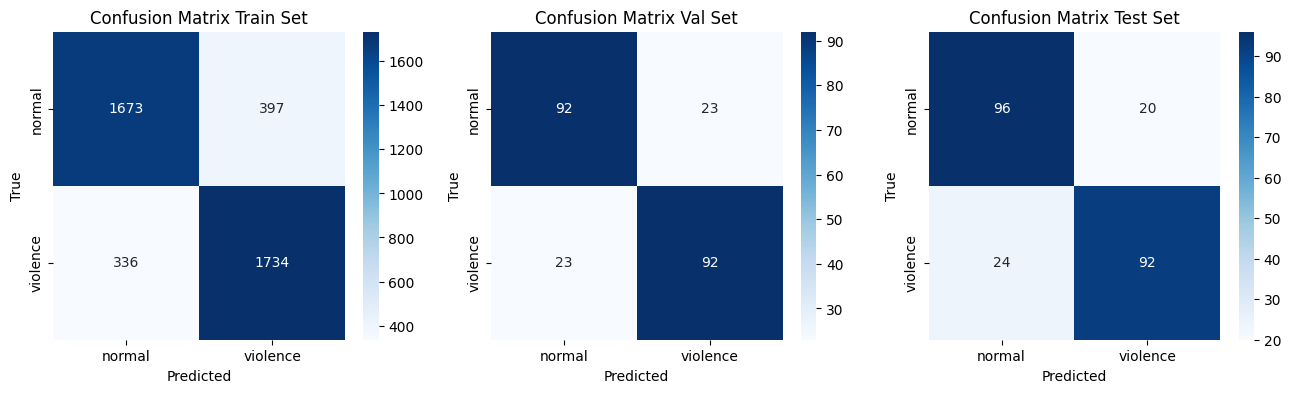

{'quantized': False, 'weight_decay': 0.01, 'dropout': 0}


PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.570300,0.564317,0.686957,0.695470,0.686957,0.683510
2,0.347700,0.490642,0.773913,0.774661,0.773913,0.773759
3,0.554700,0.489606,0.773913,0.778034,0.773913,0.773072
4,0.625000,0.511141,0.778261,0.786070,0.778261,0.776737
5,0.585900,0.487228,0.769565,0.770076,0.769565,0.769456
6,0.390600,0.485921,0.773913,0.773996,0.773913,0.773896
7,0.416000,0.485496,0.782609,0.785720,0.782609,0.782015
8,0.347700,0.480044,0.773913,0.776000,0.773913,0.773485
9,0.400400,0.479416,0.773913,0.774245,0.773913,0.773845
10,0.753900,0.482269,0.778261,0.778282,0.778261,0.778257


Train Set: {'accuracy': 0.8328502415458937, 'precision': 0.8335676818024905, 'recall': 0.8328502415458937, 'f1_score': 0.8288822947576657}
Val Set: {'accuracy': 0.7782608695652173, 'precision': 0.7818627450980391, 'recall': 0.7782608695652173, 'f1_score': 0.7649769585253456}
Test Set: {'accuracy': 0.8275862068965517, 'precision': 0.8300389338125187, 'recall': 0.8275862068965517, 'f1_score': 0.8198198198198198}


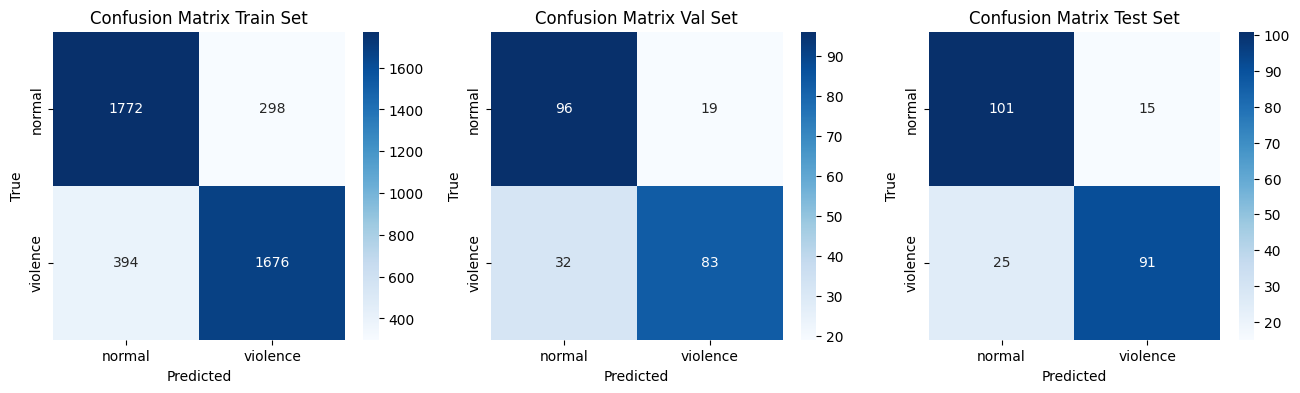

{'quantized': False, 'weight_decay': 0, 'dropout': 0.1}


PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.601600,0.645618,0.682609,0.684972,0.682609,0.681591
2,0.390600,0.506352,0.760870,0.762477,0.760870,0.760503
3,0.472700,0.507303,0.769565,0.772054,0.769565,0.769037
4,0.980500,0.536617,0.782609,0.793344,0.782609,0.780601
5,0.828100,0.496340,0.773913,0.774245,0.773913,0.773845
6,0.314500,0.506904,0.756522,0.758476,0.756522,0.756061
7,0.320300,0.503414,0.782609,0.783983,0.782609,0.782345
8,0.484400,0.494939,0.773913,0.774661,0.773913,0.773759
9,0.498000,0.498081,0.769565,0.769586,0.769565,0.769561
10,0.566400,0.500756,0.765217,0.765298,0.765217,0.765200


Train Set: {'accuracy': 0.8188405797101449, 'precision': 0.8203057229268751, 'recall': 0.8188405797101449, 'f1_score': 0.8125}
Val Set: {'accuracy': 0.782608695652174, 'precision': 0.783982980016716, 'recall': 0.782608695652174, 'f1_score': 0.7747747747747747}
Test Set: {'accuracy': 0.8103448275862069, 'precision': 0.813701923076923, 'recall': 0.8103448275862069, 'f1_score': 0.8}


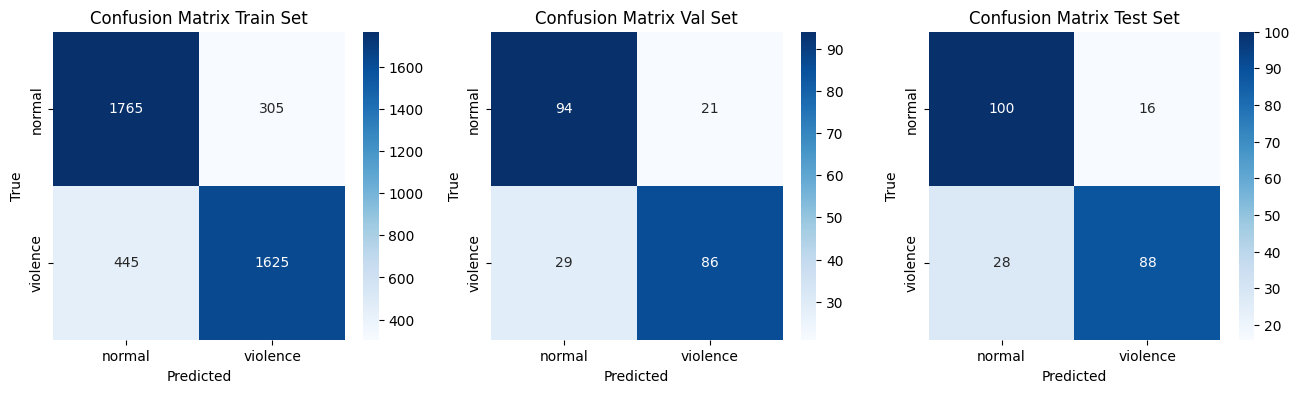

{'quantized': True, 'weight_decay': 0, 'dropout': 0}


PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.625000,0.639130,0.682609,0.691667,0.682609,0.678814
2,0.377000,0.507660,0.739130,0.739783,0.739130,0.738953
3,0.527300,0.523327,0.756522,0.757769,0.756522,0.756227
4,0.816400,0.546196,0.773913,0.780792,0.773913,0.772520
5,0.687500,0.520550,0.773913,0.774245,0.773913,0.773845
6,0.283200,0.531063,0.773913,0.776000,0.773913,0.773485
7,0.322300,0.520245,0.769565,0.771226,0.769565,0.769212
8,0.332000,0.520839,0.769565,0.769749,0.769565,0.769526


Train Set: {'accuracy': 0.8070048309178744, 'precision': 0.8071913007475657, 'recall': 0.8070048309178744, 'f1_score': 0.8093533762825101}
Val Set: {'accuracy': 0.7695652173913043, 'precision': 0.7697487893462469, 'recall': 0.7695652173913043, 'f1_score': 0.7665198237885462}
Test Set: {'accuracy': 0.7844827586206896, 'precision': 0.7845673505798394, 'recall': 0.7844827586206896, 'f1_score': 0.782608695652174}


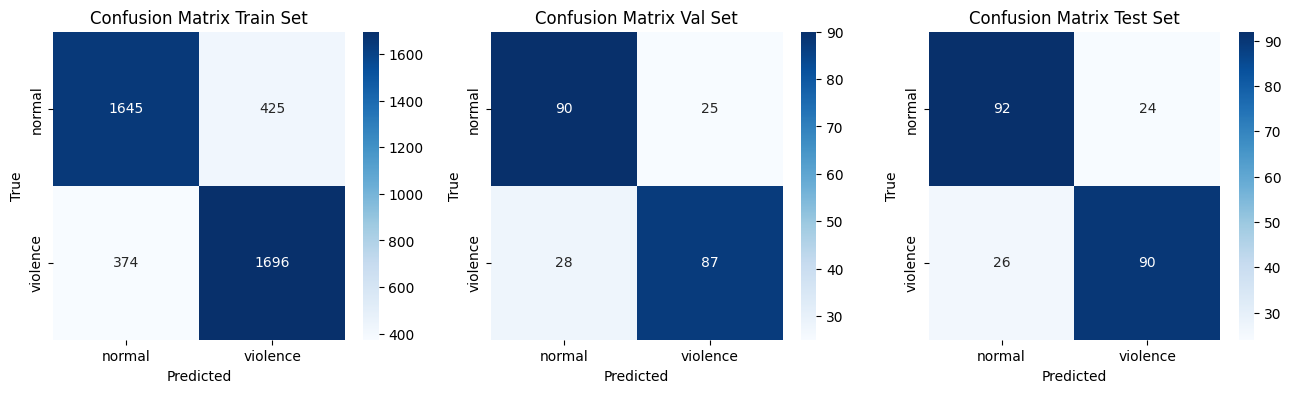

{'quantized': True, 'weight_decay': 0.01, 'dropout': 0.1}


PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.609400,0.646943,0.669565,0.692903,0.669565,0.659259
2,0.316400,0.498454,0.743478,0.744979,0.743478,0.743085
3,0.546900,0.493809,0.752174,0.753112,0.752174,0.751944
4,0.796900,0.518376,0.778261,0.787860,0.778261,0.776397
5,0.648400,0.482439,0.786957,0.788725,0.786957,0.786630
6,0.400400,0.473327,0.786957,0.787152,0.786957,0.786920
7,0.300800,0.469107,0.786957,0.788725,0.786957,0.786630
8,0.222700,0.465124,0.782609,0.784762,0.782609,0.782197
9,0.546900,0.463077,0.786957,0.787500,0.786957,0.786856


Train Set: {'accuracy': 0.8108695652173913, 'precision': 0.8127145878539841, 'recall': 0.8108695652173913, 'f1_score': 0.8178646196789952}
Val Set: {'accuracy': 0.7869565217391304, 'precision': 0.7875, 'recall': 0.7869565217391304, 'f1_score': 0.7914893617021277}
Test Set: {'accuracy': 0.8232758620689655, 'precision': 0.8232998885172799, 'recall': 0.8232758620689655, 'f1_score': 0.8240343347639485}


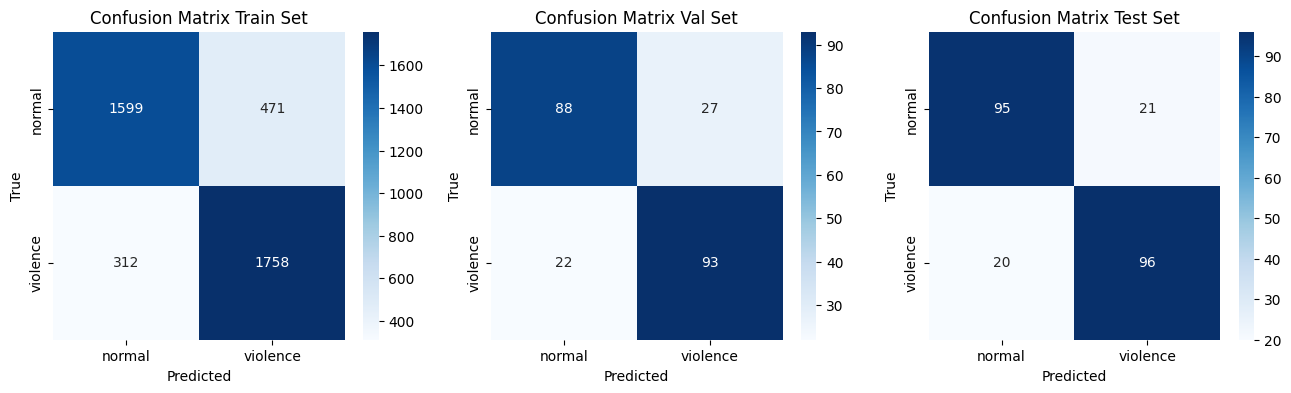

In [ ]:
hyperparameters_list = [{"quantized": False, "weight_decay": 0, "dropout": 0}, {"quantized": False, "weight_decay": 0.01, "dropout": 0},
                        {"quantized": False, "weight_decay": 0, "dropout": 0.1}, {"quantized": True, "weight_decay": 0, "dropout": 0},
                        {"quantized": True, "weight_decay": 0.01, "dropout": 0.1}]
choosen_layers_list = [[6], [11], [6, 11], [5, 6], [9, 10, 11], [5, 6, 11]]
for hyperparameters in hyperparameters_list:
    quantized, weight_decay, dropout = hyperparameters["quantized"], hyperparameters["weight_decay"], hyperparameters["dropout"]
    print(hyperparameters)

    #model
    model_class = GetModel(model_checkpoint)
    model_with_lora, model_info = model_class.get_model_with_lora(quantized = quantized, lora_rank = 8, scaling_factor = 32, dropout = dropout, chosen_layers = [6, 11])

    #trainer
    trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=weight_decay)
    trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora, pytorch_train, pytorch_val)
    trainer.train()

    evaluation_class = EvaluationClass(model_with_lora, device, class_names, tokenizer)
    evaluation_class.set_info(model_info, training_hyperparameters_info)
    evaluation_class.plot_all_matrixes(pytorch_train, pytorch_val, pytorch_test)

## **Experiment 2:** layers to apply LoRA/QLoRA most efficiently

PyTorch: setting up devices
PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.574200,0.577038,0.721739,0.733684,0.721739,0.718137
2,0.330100,0.510988,0.778261,0.784477,0.778261,0.777043
3,0.500000,0.514997,0.778261,0.781863,0.778261,0.777550
4,0.679700,0.514674,0.778261,0.784477,0.778261,0.777043
5,0.812500,0.505723,0.786957,0.793367,0.786957,0.785786
6,0.322300,0.498752,0.795652,0.798382,0.795652,0.795184
7,0.289100,0.493801,0.800000,0.804513,0.800000,0.799256
8,0.298800,0.495550,0.791304,0.797055,0.791304,0.790289
9,0.443400,0.491984,0.813043,0.815934,0.813043,0.812615
10,0.562500,0.491950,0.813043,0.815934,0.813043,0.812615


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [1]
trainable_parameters: 26114

Train Set: {'accuracy': 0.8101449275362319, 'precision': 0.8101553507364246, 'recall': 0.8101449275362319, 'f1_score': 0.8106936416184971}
Val Set: {'accuracy': 0.8130434782608695, 'precision': 0.8159340659340659, 'recall': 0.8130434782608695, 'f1_score': 0.8036529680365296}
Test Set: {'accuracy': 0.7931034482758621, 'precision': 0.795297993411201, 'recall': 0.7931034482758621, 'f1_score': 0.7837837837837838}


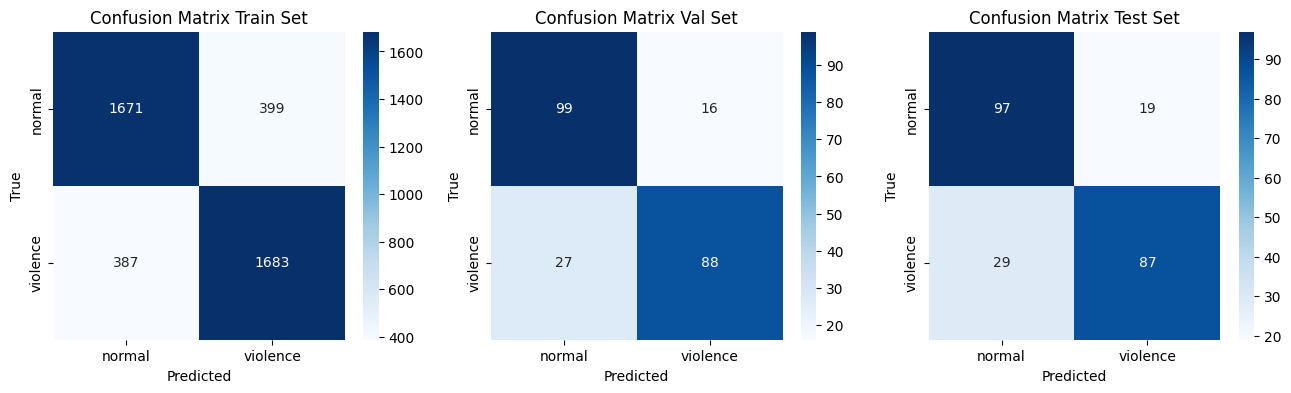

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.625000,0.660802,0.669565,0.673824,0.669565,0.667529
2,0.423800,0.536566,0.717391,0.720205,0.717391,0.716486
3,0.593800,0.514827,0.743478,0.744979,0.743478,0.743085
4,0.492200,0.514096,0.760870,0.762477,0.760870,0.760503
5,0.738300,0.507006,0.773913,0.776000,0.773913,0.773485
6,0.443400,0.507244,0.765217,0.765298,0.765217,0.765200
7,0.341800,0.501545,0.769565,0.770076,0.769565,0.769456
8,0.324200,0.502327,0.791304,0.793524,0.791304,0.790909
9,0.574200,0.502072,0.765217,0.765217,0.765217,0.765217
10,0.535200,0.501622,0.769565,0.769749,0.769565,0.769526


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [6]
trainable_parameters: 26114

Train Set: {'accuracy': 0.7946859903381642, 'precision': 0.7956467093235832, 'recall': 0.7946859903381642, 'f1_score': 0.7886623570363004}
Val Set: {'accuracy': 0.7913043478260869, 'precision': 0.7935238095238095, 'recall': 0.7913043478260869, 'f1_score': 0.7818181818181819}
Test Set: {'accuracy': 0.7586206896551724, 'precision': 0.7636363636363638, 'recall': 0.7586206896551724, 'f1_score': 0.7407407407407407}


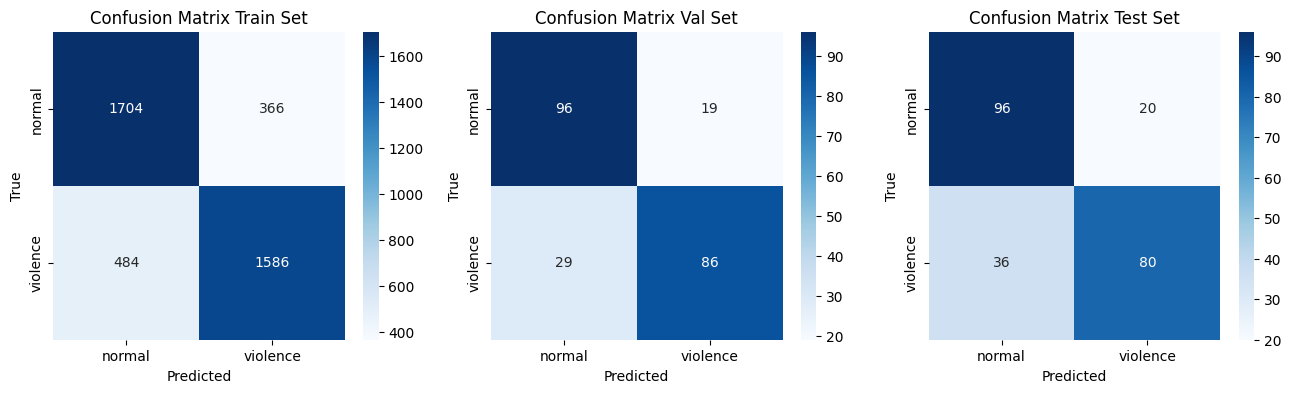

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.632800,0.664062,0.647826,0.649740,0.647826,0.646697
2,0.406200,0.525679,0.747826,0.749031,0.747826,0.747521
3,0.718800,0.502599,0.756522,0.757769,0.756522,0.756227
4,0.613300,0.504942,0.773913,0.778034,0.773913,0.773072
5,0.742200,0.506522,0.769565,0.773055,0.769565,0.768827
6,0.328100,0.515786,0.773913,0.773913,0.773913,0.773913
7,0.433600,0.508195,0.773913,0.776928,0.773913,0.773296
8,0.398400,0.507711,0.773913,0.776928,0.773913,0.773296
9,0.550800,0.510003,0.765217,0.765941,0.765217,0.765058


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [11]
trainable_parameters: 26114

Train Set: {'accuracy': 0.7719806763285024, 'precision': 0.7735745325751373, 'recall': 0.7719806763285024, 'f1_score': 0.780362959516054}
Val Set: {'accuracy': 0.7739130434782608, 'precision': 0.7739130434782608, 'recall': 0.7739130434782608, 'f1_score': 0.7739130434782608}
Test Set: {'accuracy': 0.7801724137931034, 'precision': 0.7803599315832528, 'recall': 0.7801724137931034, 'f1_score': 0.7829787234042553}


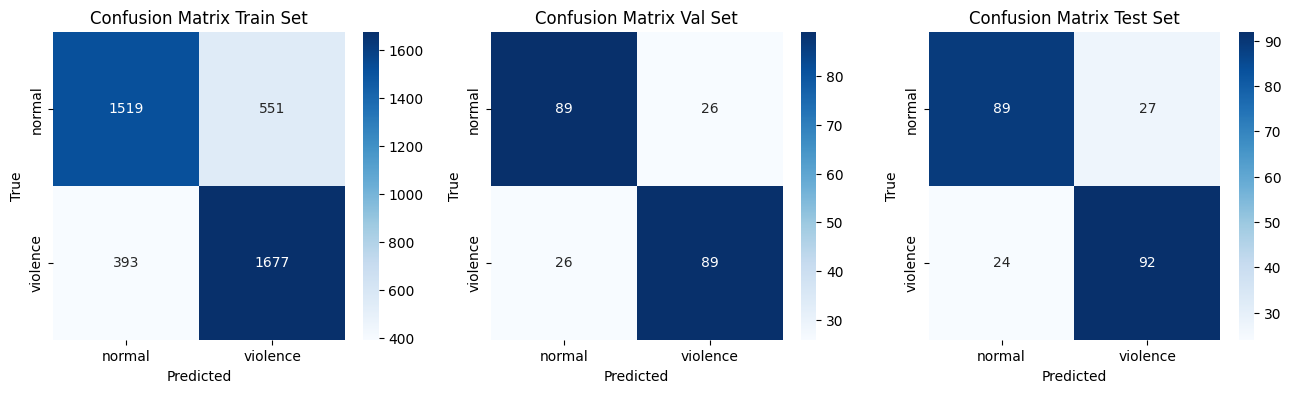

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.507800,0.553618,0.713043,0.717249,0.713043,0.711648
2,0.392600,0.502131,0.760870,0.762477,0.760870,0.760503
3,0.531200,0.502097,0.773913,0.780792,0.773913,0.772520
4,0.511700,0.536804,0.791304,0.806997,0.791304,0.788603
5,0.765600,0.488604,0.778261,0.783077,0.778261,0.777314
6,0.322300,0.487186,0.786957,0.786978,0.786957,0.786952
7,0.203100,0.498522,0.773913,0.780792,0.773913,0.772520


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [1, 6]
trainable_parameters: 50690

Train Set: {'accuracy': 0.8118357487922705, 'precision': 0.8233733920390977, 'recall': 0.8118357487922705, 'f1_score': 0.7922112563350227}
Val Set: {'accuracy': 0.7913043478260869, 'precision': 0.806996573432146, 'recall': 0.7913043478260869, 'f1_score': 0.7647058823529411}
Test Set: {'accuracy': 0.7758620689655172, 'precision': 0.7956355527237974, 'recall': 0.7758620689655172, 'f1_score': 0.7425742574257426}


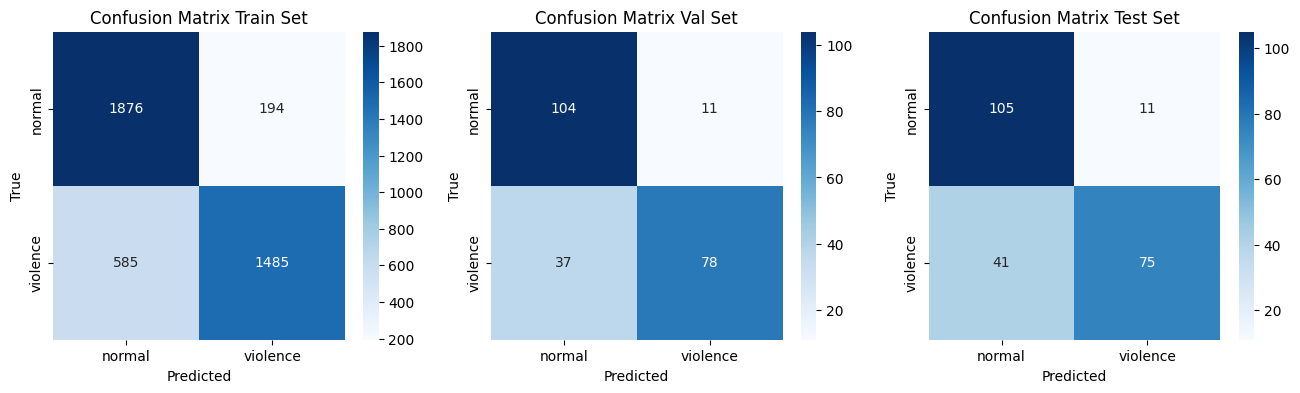

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.582000,0.614029,0.647826,0.717222,0.647826,0.617257
2,0.279300,0.507430,0.756522,0.758476,0.756522,0.756061
3,0.546900,0.517442,0.782609,0.789706,0.782609,0.781269
4,0.632800,0.556810,0.778261,0.789855,0.778261,0.776021
5,0.636700,0.512755,0.765217,0.767238,0.765217,0.764773
6,0.271500,0.506012,0.782609,0.782951,0.782609,0.782543
7,0.375000,0.521705,0.782609,0.788187,0.782609,0.781552
8,0.421900,0.508067,0.786957,0.788725,0.786957,0.786630
9,0.416000,0.503363,0.786957,0.788024,0.786957,0.786759
10,0.742200,0.504212,0.791304,0.792099,0.791304,0.791162


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [6, 11]
trainable_parameters: 50690

Train Set: {'accuracy': 0.8268115942028985, 'precision': 0.8271751221163611, 'recall': 0.8268115942028985, 'f1_score': 0.8296507483962936}
Val Set: {'accuracy': 0.7869565217391304, 'precision': 0.788023679417122, 'recall': 0.7869565217391304, 'f1_score': 0.7802690582959642}
Test Set: {'accuracy': 0.8189655172413793, 'precision': 0.8189655172413793, 'recall': 0.8189655172413793, 'f1_score': 0.8189655172413793}


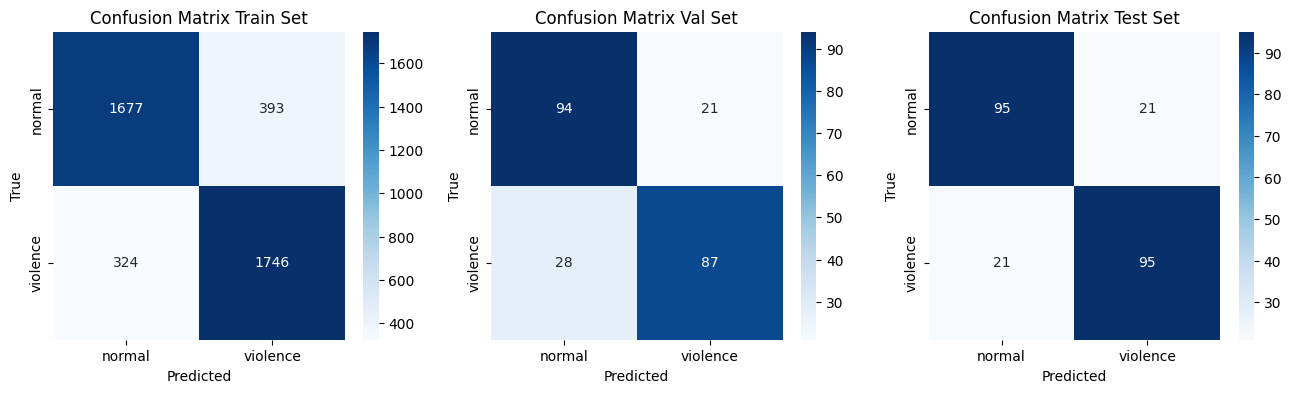

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.609400,0.644124,0.686957,0.686957,0.686957,0.686957
2,0.377000,0.504620,0.747826,0.749714,0.747826,0.747348
3,0.435500,0.510572,0.760870,0.761364,0.760870,0.760757
4,1.015600,0.530791,0.765217,0.775292,0.765217,0.763049
5,0.769500,0.501002,0.786957,0.789606,0.786957,0.786468
6,0.316400,0.496484,0.786957,0.787500,0.786957,0.786856
7,0.219700,0.503957,0.778261,0.784477,0.778261,0.777043
8,0.293000,0.501121,0.778261,0.783077,0.778261,0.777314
9,0.656200,0.494395,0.782609,0.783983,0.782609,0.782345


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [5, 6]
trainable_parameters: 50690

Train Set: {'accuracy': 0.8171497584541063, 'precision': 0.8173133434095525, 'recall': 0.8171497584541063, 'f1_score': 0.8192022928110819}
Val Set: {'accuracy': 0.7869565217391304, 'precision': 0.7875, 'recall': 0.7869565217391304, 'f1_score': 0.7822222222222223}
Test Set: {'accuracy': 0.8189655172413793, 'precision': 0.8193452380952382, 'recall': 0.8189655172413793, 'f1_score': 0.8157894736842105}


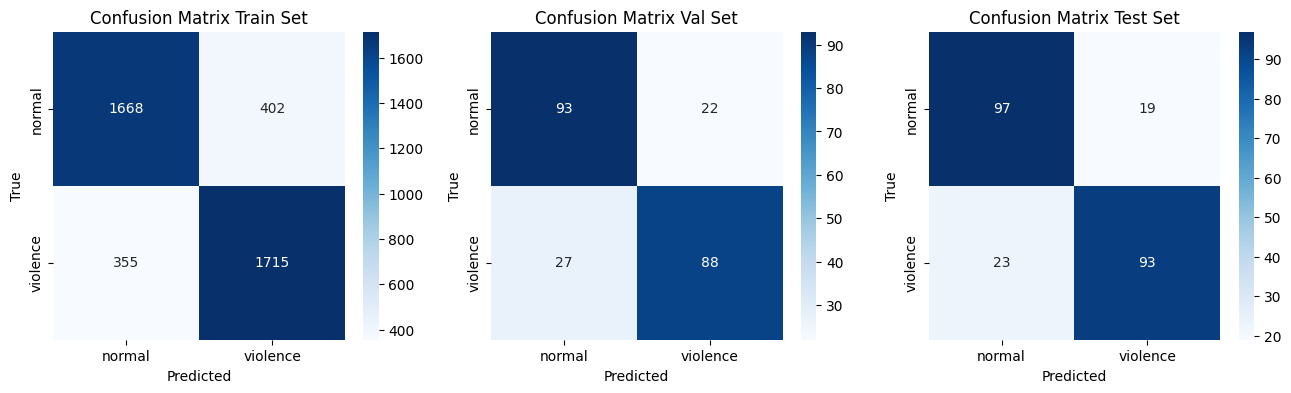

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.492200,0.529552,0.726087,0.739277,0.726087,0.722259
2,0.249000,0.493045,0.786957,0.793367,0.786957,0.785786
3,0.462900,0.504857,0.786957,0.791923,0.786957,0.786047
4,0.558600,0.505452,0.778261,0.783077,0.778261,0.777314
5,0.632800,0.477395,0.791304,0.793524,0.791304,0.790909
6,0.400400,0.479891,0.778261,0.779976,0.778261,0.777921
7,0.115200,0.461651,0.821739,0.830768,0.821739,0.820514
8,0.154300,0.448370,0.826087,0.826977,0.826087,0.825969
9,0.335900,0.448166,0.830435,0.831664,0.830435,0.830278
10,0.371100,0.455435,0.813043,0.813067,0.813043,0.813040


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [0, 1, 5]
trainable_parameters: 75266

Train Set: {'accuracy': 0.8898550724637682, 'precision': 0.8898681745238235, 'recall': 0.8898550724637682, 'f1_score': 0.8895348837209303}
Val Set: {'accuracy': 0.8304347826086956, 'precision': 0.8316636308439587, 'recall': 0.8304347826086956, 'f1_score': 0.8251121076233184}
Test Set: {'accuracy': 0.8448275862068966, 'precision': 0.8485576923076923, 'recall': 0.8448275862068966, 'f1_score': 0.8363636363636363}


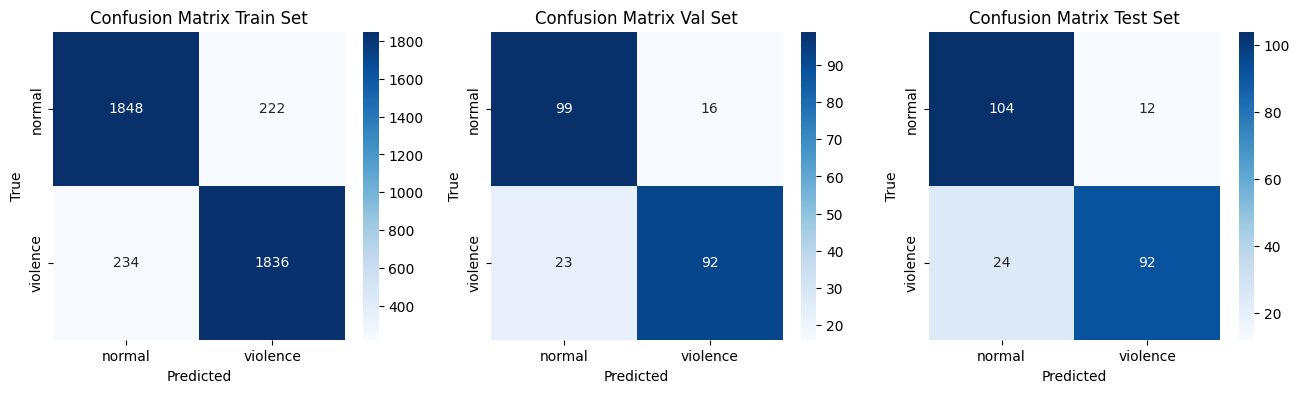

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.582000,0.630231,0.643478,0.697143,0.643478,0.617444
2,0.294900,0.511668,0.747826,0.747901,0.747826,0.747807
3,0.414100,0.540693,0.765217,0.771878,0.765217,0.763771
4,0.902300,0.572656,0.760870,0.771739,0.760870,0.758454
5,0.593800,0.518427,0.765217,0.765298,0.765217,0.765200
6,0.377000,0.516542,0.769565,0.770568,0.769565,0.769352
7,0.238300,0.528176,0.782609,0.786860,0.782609,0.781800
8,0.320300,0.515251,0.773913,0.773996,0.773913,0.773896
9,0.527300,0.515744,0.773913,0.773996,0.773913,0.773896
10,0.470700,0.516865,0.778261,0.778450,0.778261,0.778223


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [5, 6, 11]
trainable_parameters: 75266

Train Set: {'accuracy': 0.8355072463768116, 'precision': 0.8378671676023174, 'recall': 0.8355072463768116, 'f1_score': 0.8283337534660953}
Val Set: {'accuracy': 0.782608695652174, 'precision': 0.7868600813569729, 'recall': 0.782608695652174, 'f1_score': 0.7685185185185185}
Test Set: {'accuracy': 0.8146551724137931, 'precision': 0.8200060464061673, 'recall': 0.8146551724137931, 'f1_score': 0.8018433179723502}


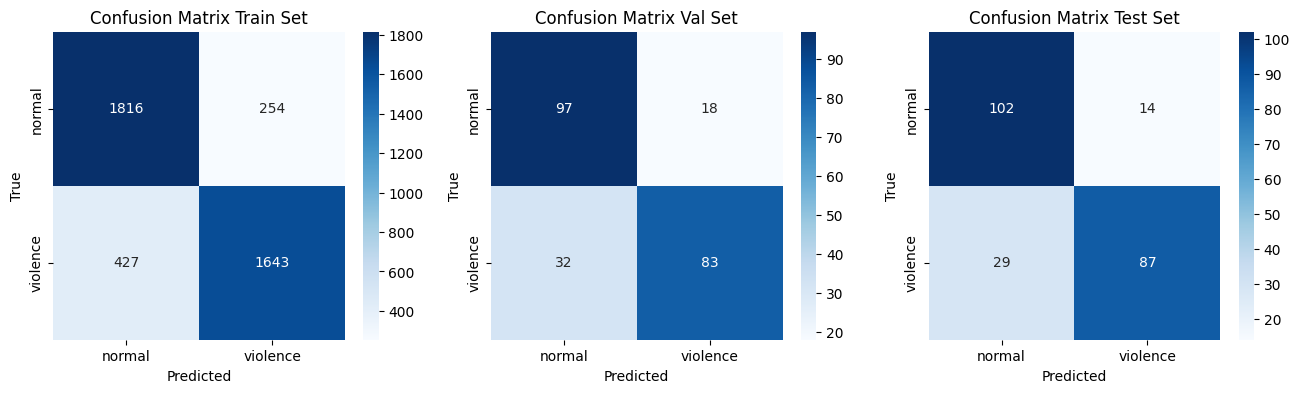

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.593800,0.639572,0.669565,0.717528,0.669565,0.650288
2,0.293000,0.508560,0.760870,0.761840,0.760870,0.760648
3,0.605500,0.546773,0.743478,0.750311,0.743478,0.741716
4,0.613300,0.575221,0.739130,0.750020,0.739130,0.736259
5,0.871100,0.533747,0.760870,0.761047,0.760870,0.760829
6,0.484400,0.542731,0.760870,0.761840,0.760870,0.760648
7,0.308600,0.547198,0.756522,0.760381,0.756522,0.755616
8,0.221700,0.536634,0.756522,0.757769,0.756522,0.756227


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [9, 10, 11]
trainable_parameters: 75266

Train Set: {'accuracy': 0.8205314009661836, 'precision': 0.8206697748871074, 'recall': 0.8205314009661836, 'f1_score': 0.8223762849629452}
Val Set: {'accuracy': 0.7608695652173914, 'precision': 0.761047215496368, 'recall': 0.7608695652173914, 'f1_score': 0.7577092511013216}
Test Set: {'accuracy': 0.8017241379310345, 'precision': 0.8031660692951015, 'recall': 0.8017241379310345, 'f1_score': 0.7946428571428571}


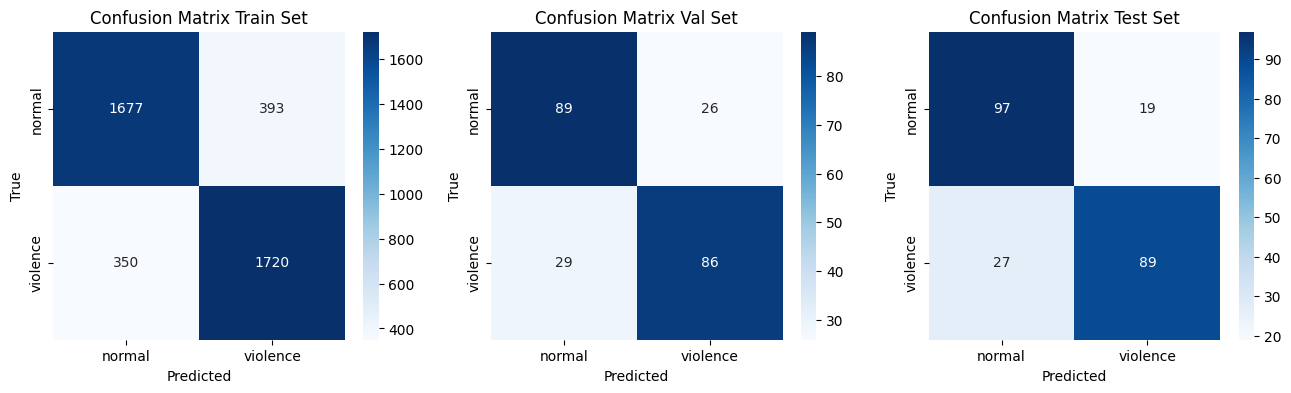

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.585900,0.594956,0.656522,0.717803,0.656522,0.630533
2,0.283200,0.494956,0.782609,0.791423,0.782609,0.780952
3,0.617200,0.490642,0.791304,0.795687,0.791304,0.790528
4,0.718800,0.531776,0.773913,0.782456,0.773913,0.772190
5,0.589800,0.493699,0.791304,0.792721,0.791304,0.791052
6,0.324200,0.483772,0.786957,0.786978,0.786957,0.786952
7,0.365200,0.495346,0.786957,0.790671,0.786957,0.786274
8,0.445300,0.477463,0.786957,0.786978,0.786957,0.786952


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [4, 5, 6, 7]
trainable_parameters: 99842

Train Set: {'accuracy': 0.8543478260869565, 'precision': 0.8546975652204384, 'recall': 0.8543478260869565, 'f1_score': 0.8520245398773006}
Val Set: {'accuracy': 0.7913043478260869, 'precision': 0.7927209178633842, 'recall': 0.7913043478260869, 'f1_score': 0.7837837837837838}
Test Set: {'accuracy': 0.853448275862069, 'precision': 0.8603030303030303, 'recall': 0.853448275862069, 'f1_score': 0.8425925925925926}


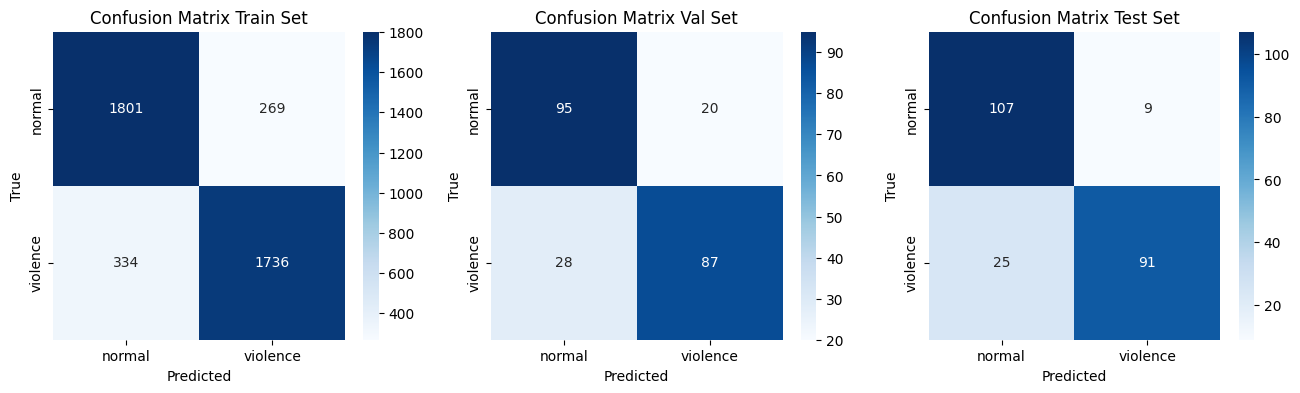

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.558600,0.600442,0.652174,0.709091,0.652174,0.626775
2,0.291000,0.505367,0.765217,0.771878,0.765217,0.763771
3,0.519500,0.490336,0.773913,0.780792,0.773913,0.772520
4,0.625000,0.527683,0.782609,0.793344,0.782609,0.780601
5,0.578100,0.470177,0.795652,0.796212,0.795652,0.795556
6,0.334000,0.470168,0.791304,0.791657,0.791304,0.791241
7,0.384800,0.478337,0.800000,0.803302,0.800000,0.799454
8,0.449200,0.466585,0.813043,0.813636,0.813043,0.812955
9,0.459000,0.464589,0.808696,0.808789,0.808696,0.808681
10,0.593800,0.469064,0.800000,0.800000,0.800000,0.800000


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [5, 6, 10, 11]
trainable_parameters: 99842

Train Set: {'accuracy': 0.8599033816425121, 'precision': 0.8599440390475621, 'recall': 0.8599033816425121, 'f1_score': 0.8606439211917347}
Val Set: {'accuracy': 0.8173913043478261, 'precision': 0.8177757589522295, 'recall': 0.8173913043478261, 'f1_score': 0.8141592920353983}
Test Set: {'accuracy': 0.8362068965517241, 'precision': 0.8371087928464978, 'recall': 0.8362068965517241, 'f1_score': 0.831858407079646}


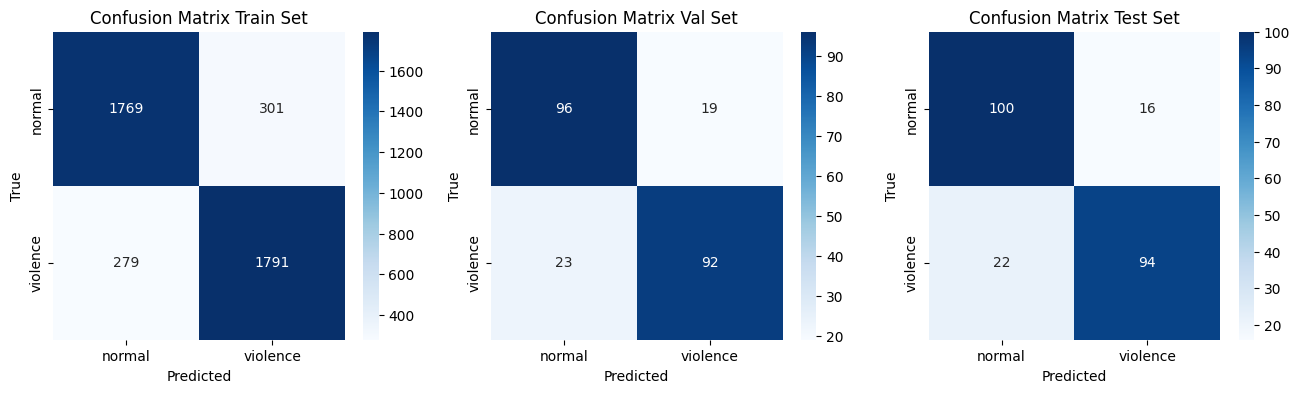

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.562500,0.611889,0.639130,0.704444,0.639130,0.607807
2,0.261700,0.505554,0.760870,0.764246,0.760870,0.760103
3,0.593800,0.527276,0.765217,0.775292,0.765217,0.763049
4,0.761700,0.536549,0.778261,0.792063,0.778261,0.775610
5,0.660200,0.492009,0.795652,0.795854,0.795652,0.795617
6,0.199200,0.501894,0.782609,0.785720,0.782609,0.782015
7,0.339800,0.484086,0.800000,0.801459,0.800000,0.799758
8,0.412100,0.479467,0.800000,0.800363,0.800000,0.799939
9,0.335900,0.488961,0.782609,0.783983,0.782609,0.782345
10,0.451200,0.492536,0.778261,0.779976,0.778261,0.777921


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [6, 9, 10, 11]
trainable_parameters: 99842

Train Set: {'accuracy': 0.8442028985507246, 'precision': 0.8446315062888313, 'recall': 0.8442028985507246, 'f1_score': 0.8469024448136719}
Val Set: {'accuracy': 0.8043478260869565, 'precision': 0.8045550847457628, 'recall': 0.8043478260869565, 'f1_score': 0.8068669527896996}
Test Set: {'accuracy': 0.8017241379310345, 'precision': 0.8020833333333333, 'recall': 0.8017241379310345, 'f1_score': 0.8050847457627118}


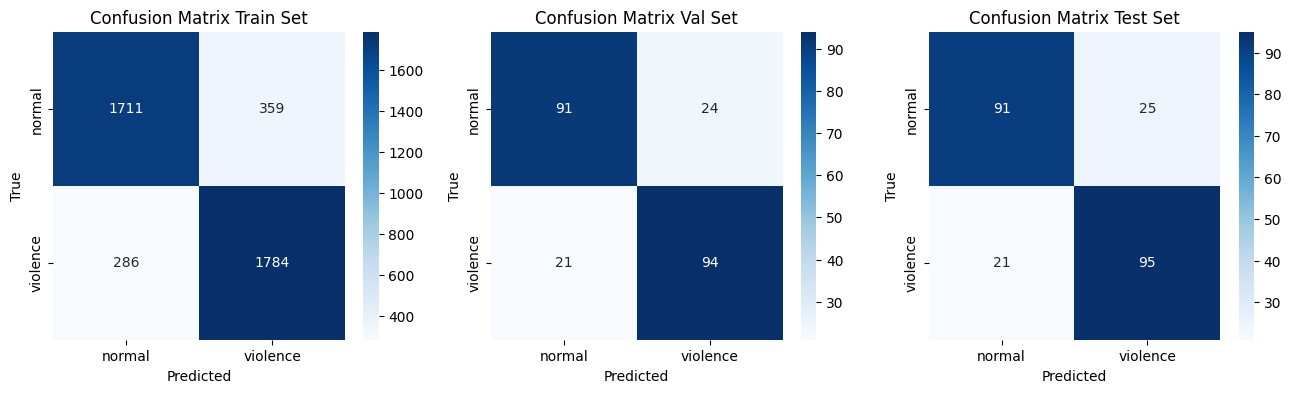

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.609400,0.609885,0.639130,0.710623,0.639130,0.605668
2,0.314500,0.504679,0.773913,0.775245,0.773913,0.773639
3,0.535200,0.515082,0.782609,0.785720,0.782609,0.782015
4,0.699200,0.536107,0.778261,0.786070,0.778261,0.776737
5,0.578100,0.508687,0.778261,0.778788,0.778261,0.778156
6,0.335900,0.509817,0.765217,0.767238,0.765217,0.764773


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [7, 8, 9, 10, 11, 12]
trainable_parameters: 124418

Train Set: {'accuracy': 0.8111111111111111, 'precision': 0.8141623327592498, 'recall': 0.8111111111111111, 'f1_score': 0.8013211382113821}
Val Set: {'accuracy': 0.782608695652174, 'precision': 0.785719746196774, 'recall': 0.782608695652174, 'f1_score': 0.7706422018348624}
Test Set: {'accuracy': 0.771551724137931, 'precision': 0.777511961722488, 'recall': 0.771551724137931, 'f1_score': 0.7534883720930232}


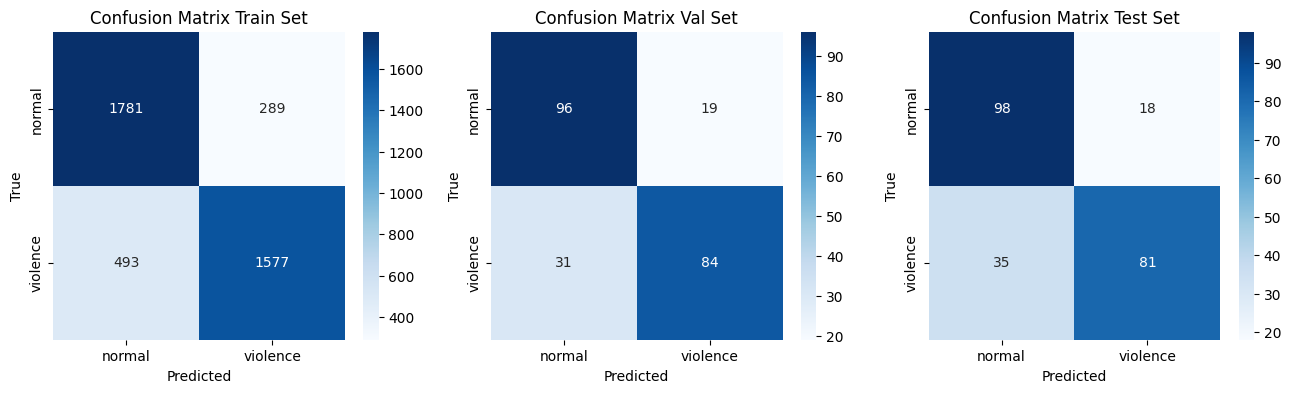

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.308600,0.508976,0.752174,0.760873,0.752174,0.750091
2,0.215800,0.477259,0.795652,0.799479,0.795652,0.794997
3,0.531200,0.498268,0.804348,0.817029,0.804348,0.802372
4,0.847700,0.526664,0.800000,0.821907,0.800000,0.796538
5,0.484400,0.442086,0.813043,0.814973,0.813043,0.812757
6,0.043500,0.436600,0.821739,0.822348,0.821739,0.821655
7,0.175800,0.431793,0.813043,0.814208,0.813043,0.812870
8,0.056900,0.427700,0.847826,0.849970,0.847826,0.847593
9,0.158200,0.427921,0.826087,0.826482,0.826087,0.826034
10,0.441400,0.440965,0.834783,0.835696,0.834783,0.834670


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 296450

Train Set: {'accuracy': 0.9263285024154589, 'precision': 0.926888900573111, 'recall': 0.9263285024154589, 'f1_score': 0.9276393831553974}
Val Set: {'accuracy': 0.8478260869565217, 'precision': 0.8499695678636641, 'recall': 0.8478260869565217, 'f1_score': 0.8535564853556485}
Test Set: {'accuracy': 0.8706896551724138, 'precision': 0.8724611708482676, 'recall': 0.8706896551724138, 'f1_score': 0.875}


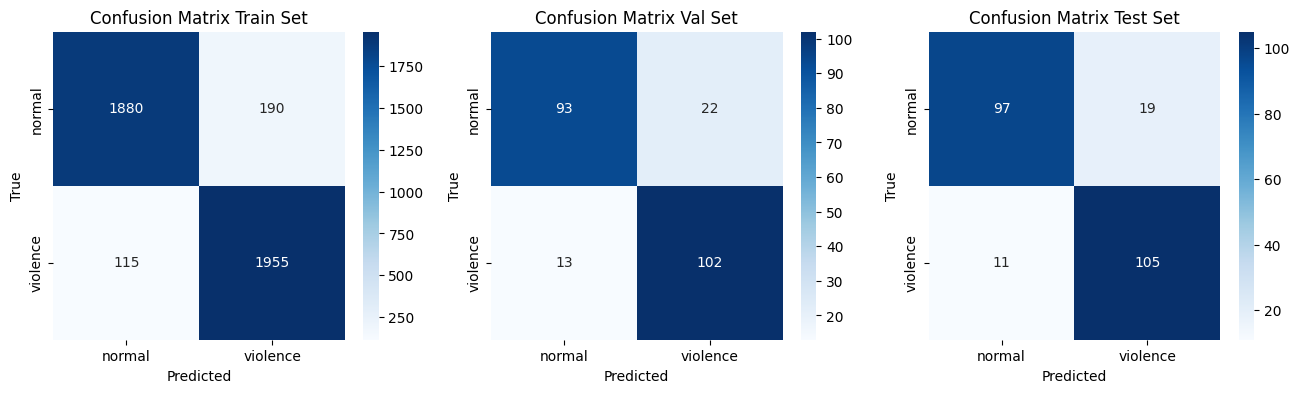

In [ ]:
trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=0.01)
choosen_layers_list = [[1], [6], [11], [1, 6], [6, 11], [5, 6], [0, 1, 5], [5, 6, 11], [9, 10, 11], [4, 5, 6, 7], [5, 6, 10, 11], [6, 9, 10, 11], [7,8,9,10,11,12], list(range(12))]

for choosen_layers in choosen_layers_list:
    #model
    model_class = GetModel(model_checkpoint)
    model_with_lora, model_info = model_class.get_model_with_lora(quantized = True, lora_rank = 8, scaling_factor = 32, dropout = 0.1, chosen_layers = choosen_layers)

    #trainer
    trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=0.01)
    trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora, pytorch_train, pytorch_val)
    trainer.train()

    #evaluation
    print(model_info)
    # print("train set: ", trainer.evaluate(eval_dataset = pytorch_train))
    # print("val set: ", trainer.evaluate(eval_dataset = pytorch_val))
    # print("test set: ", trainer.evaluate(eval_dataset = pytorch_test))
    evaluation_class = EvaluationClass(model_with_lora, device, class_names, tokenizer)
    evaluation_class.set_info(model_info, training_hyperparameters_info)
    evaluation_class.plot_all_matrixes(pytorch_train, pytorch_val, pytorch_test)



## **Experiment 3** lora rank / scaling factor

PyTorch: setting up devices
PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.605500,0.614249,0.634783,0.707243,0.634783,0.599801
2,0.247100,0.485403,0.778261,0.780830,0.778261,0.777753
3,0.519500,0.492391,0.782609,0.789706,0.782609,0.781269
4,0.945300,0.552641,0.778261,0.797158,0.778261,0.774679
5,0.668000,0.477484,0.795652,0.796752,0.795652,0.795463
6,0.312500,0.489912,0.800000,0.800819,0.800000,0.799864
7,0.142600,0.486774,0.808696,0.812094,0.808696,0.808173
8,0.296900,0.467863,0.813043,0.813257,0.813043,0.813012
9,0.398400,0.469671,0.817391,0.817487,0.817391,0.817377
10,0.410200,0.473361,0.813043,0.813636,0.813043,0.812955


Train Set: {'accuracy': 0.8765700483091787, 'precision': 0.8767642820833911, 'recall': 0.8765700483091787, 'f1_score': 0.8779555767852878}
Val Set: {'accuracy': 0.8173913043478261, 'precision': 0.817487330761667, 'recall': 0.8173913043478261, 'f1_score': 0.8189655172413793}
Test Set: {'accuracy': 0.8620689655172413, 'precision': 0.8630402384500745, 'recall': 0.8620689655172413, 'f1_score': 0.8584070796460177}


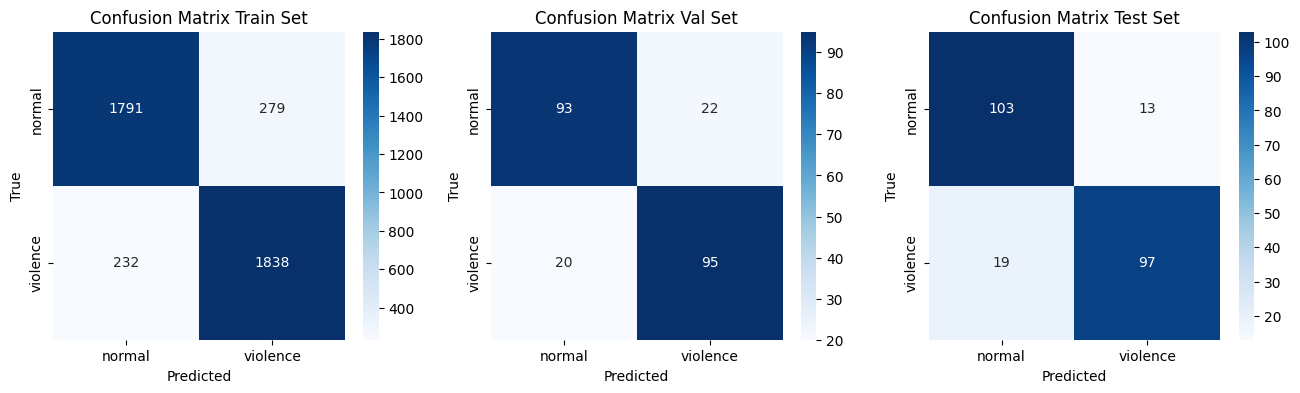

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.566400,0.609545,0.634783,0.714114,0.634783,0.597500
2,0.283200,0.493122,0.756522,0.760381,0.756522,0.755616
3,0.470700,0.480265,0.765217,0.768137,0.765217,0.764577
4,0.718800,0.531454,0.782609,0.795478,0.782609,0.780216
5,0.445300,0.474677,0.786957,0.787500,0.786957,0.786856
6,0.293000,0.491474,0.800000,0.800819,0.800000,0.799864
7,0.240200,0.522147,0.791304,0.797055,0.791304,0.790289
8,0.196300,0.479552,0.800000,0.800091,0.800000,0.799985
9,0.466800,0.483203,0.804348,0.804371,0.804348,0.804344
10,0.410200,0.480707,0.804348,0.804555,0.804348,0.804315


Train Set: {'accuracy': 0.9002415458937199, 'precision': 0.9007399339793638, 'recall': 0.9002415458937199, 'f1_score': 0.9019700925706148}
Val Set: {'accuracy': 0.8043478260869565, 'precision': 0.8043708408953418, 'recall': 0.8043478260869565, 'f1_score': 0.8051948051948052}
Test Set: {'accuracy': 0.8706896551724138, 'precision': 0.8707998810585786, 'recall': 0.8706896551724138, 'f1_score': 0.8717948717948718}


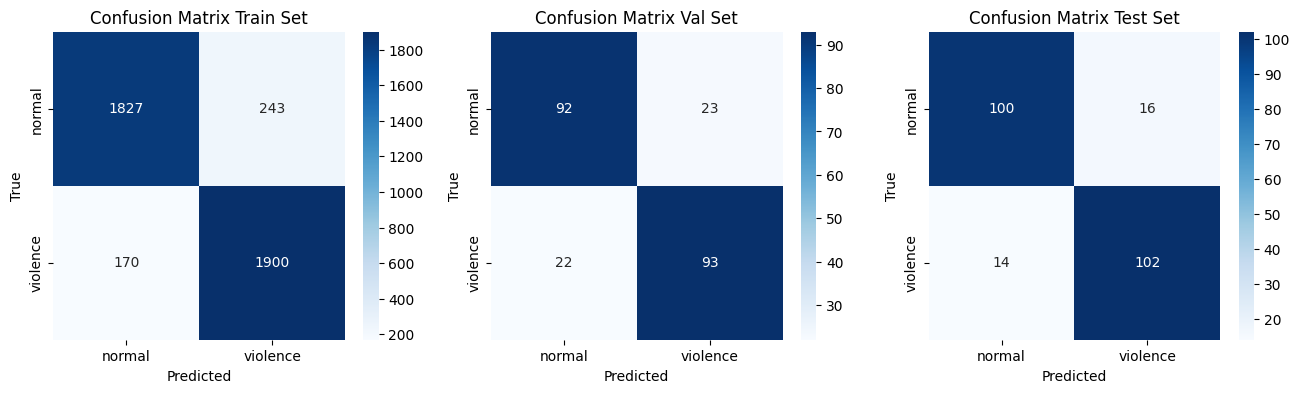

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.507800,0.568937,0.678261,0.739073,0.678261,0.656411
2,0.287100,0.495143,0.765217,0.770453,0.765217,0.764076
3,0.472700,0.475815,0.765217,0.768137,0.765217,0.764577
4,0.726600,0.532643,0.782609,0.797832,0.782609,0.779795
5,0.431600,0.474524,0.795652,0.795854,0.795652,0.795617
6,0.322300,0.497690,0.808696,0.809538,0.808696,0.808565
7,0.220700,0.526495,0.795652,0.800769,0.795652,0.794779
8,0.187500,0.481963,0.804348,0.804924,0.804348,0.804255
9,0.435500,0.488230,0.808696,0.808696,0.808696,0.808696
10,0.416000,0.483084,0.808696,0.809070,0.808696,0.808638


Train Set: {'accuracy': 0.9096618357487922, 'precision': 0.9099009900990099, 'recall': 0.9096618357487922, 'f1_score': 0.9107398568019093}
Val Set: {'accuracy': 0.808695652173913, 'precision': 0.808695652173913, 'recall': 0.808695652173913, 'f1_score': 0.808695652173913}
Test Set: {'accuracy': 0.8706896551724138, 'precision': 0.8707998810585786, 'recall': 0.8706896551724138, 'f1_score': 0.8717948717948718}


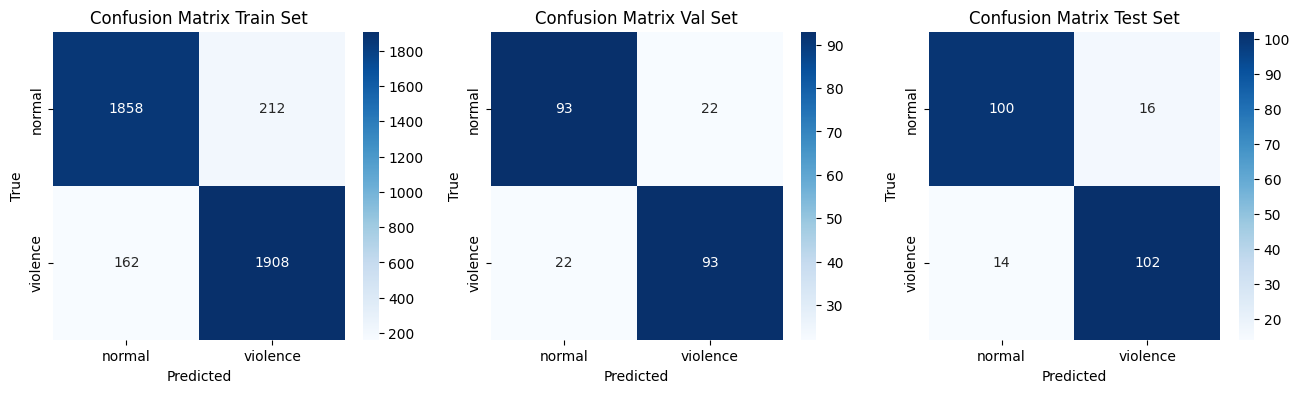

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.412100,0.512432,0.747826,0.757240,0.747826,0.745498
2,0.283200,0.493580,0.765217,0.771878,0.765217,0.763771
3,0.478500,0.470448,0.760870,0.762477,0.760870,0.760503
4,0.730500,0.527717,0.778261,0.789855,0.778261,0.776021
5,0.410200,0.475442,0.795652,0.795854,0.795652,0.795617
6,0.337900,0.503567,0.795652,0.796212,0.795652,0.795556
7,0.210000,0.524253,0.804348,0.808287,0.804348,0.803721
8,0.198200,0.482745,0.800000,0.800363,0.800000,0.799939
9,0.369100,0.490642,0.804348,0.804555,0.804348,0.804315
10,0.416000,0.484001,0.804348,0.804555,0.804348,0.804315


Train Set: {'accuracy': 0.9169082125603865, 'precision': 0.9170639460229263, 'recall': 0.9169082125603865, 'f1_score': 0.9177033492822967}
Val Set: {'accuracy': 0.8043478260869565, 'precision': 0.8045550847457628, 'recall': 0.8043478260869565, 'f1_score': 0.801762114537445}
Test Set: {'accuracy': 0.8620689655172413, 'precision': 0.8620689655172413, 'recall': 0.8620689655172413, 'f1_score': 0.8620689655172413}


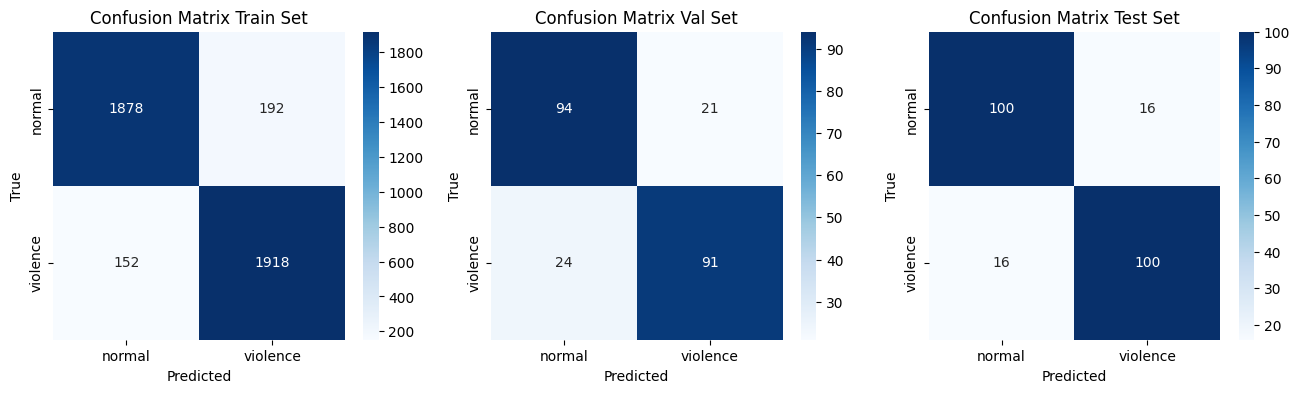

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.478500,0.550051,0.695652,0.725766,0.695652,0.685153
2,0.265600,0.499966,0.765217,0.769207,0.765217,0.764344
3,0.570300,0.479195,0.782609,0.784762,0.782609,0.782197
4,0.628900,0.524728,0.795652,0.805851,0.795652,0.793934
5,0.511700,0.470754,0.786957,0.787152,0.786957,0.786920
6,0.237300,0.483764,0.795652,0.797474,0.795652,0.795339
7,0.082500,0.487636,0.821739,0.824710,0.821739,0.821330
8,0.152300,0.475408,0.821739,0.827308,0.821739,0.820978
9,0.369100,0.468512,0.821739,0.821958,0.821739,0.821709
10,0.396500,0.469293,0.813043,0.815934,0.813043,0.812615


Train Set: {'accuracy': 0.9113526570048309, 'precision': 0.9115832834987235, 'recall': 0.9113526570048309, 'f1_score': 0.9123895917880163}
Val Set: {'accuracy': 0.8217391304347826, 'precision': 0.8219582324455206, 'recall': 0.8217391304347826, 'f1_score': 0.8240343347639485}
Test Set: {'accuracy': 0.8620689655172413, 'precision': 0.8621766280107047, 'recall': 0.8620689655172413, 'f1_score': 0.8632478632478633}


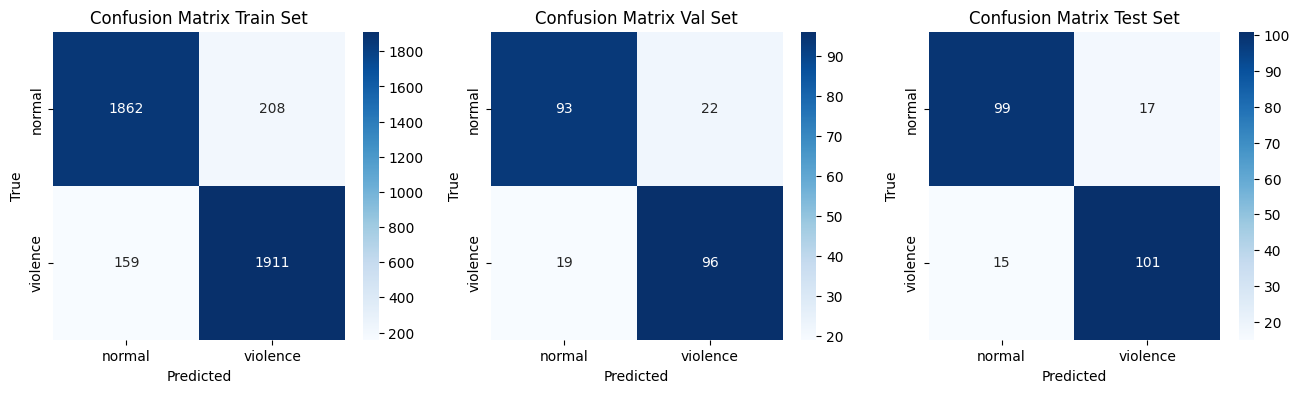

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.349600,0.525042,0.734783,0.748480,0.734783,0.731077
2,0.235400,0.502310,0.782609,0.789706,0.782609,0.781269
3,0.570300,0.471535,0.769565,0.769749,0.769565,0.769526
4,0.570300,0.497928,0.813043,0.820037,0.813043,0.812016
5,0.478500,0.462058,0.808696,0.808789,0.808696,0.808681
6,0.213900,0.478295,0.817391,0.818258,0.817391,0.817267
7,0.055200,0.478736,0.830435,0.831664,0.830435,0.830278
8,0.163100,0.478702,0.821739,0.827308,0.821739,0.820978
9,0.279300,0.461175,0.830435,0.831061,0.830435,0.830355
10,0.377000,0.466236,0.826087,0.829677,0.826087,0.825612


Train Set: {'accuracy': 0.9260869565217391, 'precision': 0.9263356996076966, 'recall': 0.9260869565217391, 'f1_score': 0.9269689737470167}
Val Set: {'accuracy': 0.8260869565217391, 'precision': 0.8269770263098035, 'recall': 0.8260869565217391, 'f1_score': 0.8305084745762712}
Test Set: {'accuracy': 0.8577586206896551, 'precision': 0.857785209959123, 'recall': 0.8577586206896551, 'f1_score': 0.8583690987124464}


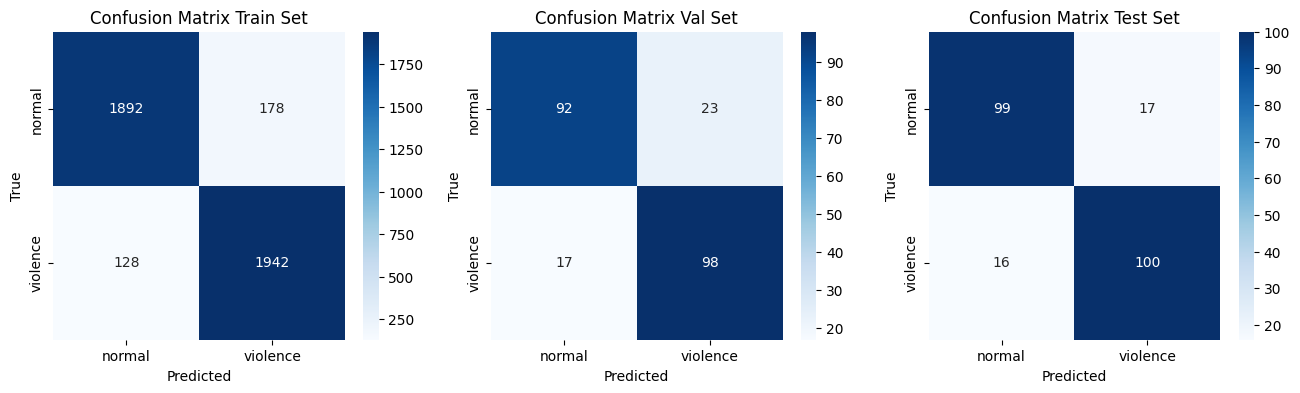

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.332000,0.533042,0.739130,0.754200,0.739130,0.735206
2,0.214800,0.505622,0.778261,0.784477,0.778261,0.777043
3,0.562500,0.469158,0.800000,0.800091,0.800000,0.799985
4,0.539100,0.492289,0.817391,0.823656,0.817391,0.816503
5,0.474600,0.458798,0.813043,0.813067,0.813043,0.813040
6,0.192400,0.478261,0.834783,0.836411,0.834783,0.834582
7,0.048300,0.474626,0.839130,0.839361,0.839130,0.839103
8,0.166000,0.479518,0.826087,0.832524,0.826087,0.825241
9,0.267600,0.458594,0.830435,0.830660,0.830435,0.830406
10,0.361300,0.464334,0.839130,0.842262,0.839130,0.838762


Train Set: {'accuracy': 0.9265700483091788, 'precision': 0.9268394066969377, 'recall': 0.9265700483091788, 'f1_score': 0.9256360078277887}
Val Set: {'accuracy': 0.8391304347826087, 'precision': 0.8393613801452785, 'recall': 0.8391304347826087, 'f1_score': 0.8370044052863436}
Test Set: {'accuracy': 0.8491379310344828, 'precision': 0.8504139628552249, 'recall': 0.8491379310344828, 'f1_score': 0.8444444444444444}


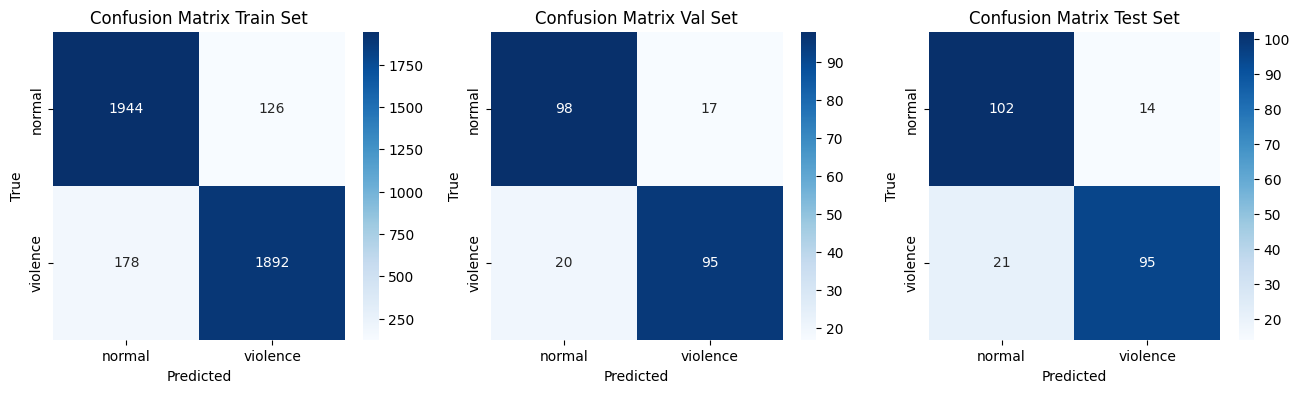

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.334000,0.545754,0.730435,0.749775,0.730435,0.725114
2,0.210000,0.506063,0.773913,0.780792,0.773913,0.772520
3,0.511700,0.465523,0.800000,0.800819,0.800000,0.799864
4,0.535200,0.486073,0.817391,0.820885,0.817391,0.816893
5,0.451200,0.451393,0.830435,0.830460,0.830435,0.830432
6,0.168900,0.472758,0.834783,0.836411,0.834783,0.834582
7,0.043500,0.466780,0.843478,0.843582,0.843478,0.843466
8,0.146500,0.476359,0.826087,0.834276,0.826087,0.825015
9,0.231400,0.450611,0.839130,0.839773,0.839130,0.839054
10,0.371100,0.459171,0.843478,0.847259,0.843478,0.843051


Train Set: {'accuracy': 0.9330917874396135, 'precision': 0.9332455755140976, 'recall': 0.9330917874396135, 'f1_score': 0.9324554986588637}
Val Set: {'accuracy': 0.8434782608695652, 'precision': 0.8435821798653658, 'recall': 0.8434782608695652, 'f1_score': 0.8421052631578947}
Test Set: {'accuracy': 0.8577586206896551, 'precision': 0.8579980664832305, 'recall': 0.8577586206896551, 'f1_score': 0.8558951965065502}


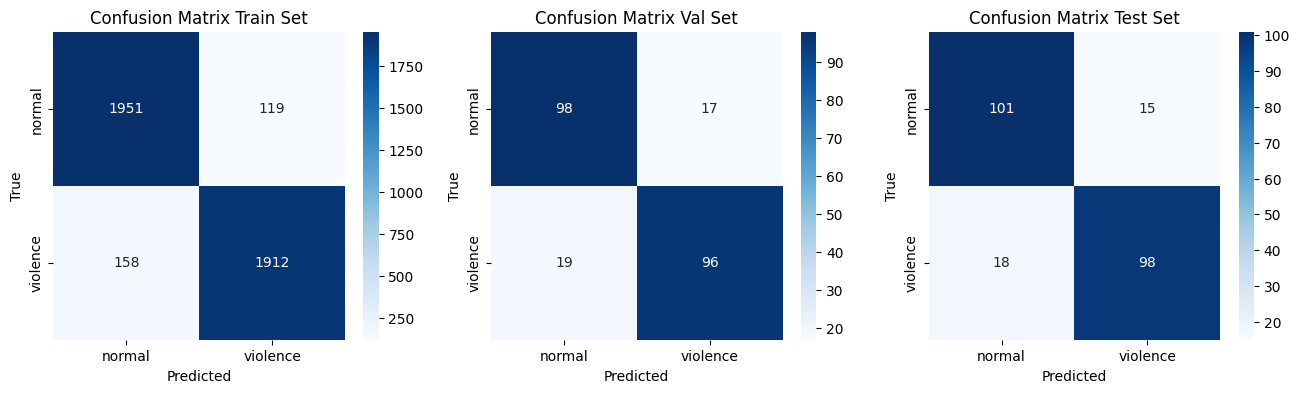

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.380900,0.534052,0.721739,0.740349,0.721739,0.716246
2,0.212900,0.506522,0.782609,0.793344,0.782609,0.780601
3,0.535200,0.466576,0.800000,0.800363,0.800000,0.799939
4,0.722700,0.512194,0.804348,0.814847,0.804348,0.802703
5,0.343800,0.461430,0.821739,0.821763,0.821739,0.821736
6,0.130900,0.470907,0.834783,0.834884,0.834783,0.834770
7,0.072300,0.476019,0.826087,0.829677,0.826087,0.825612
8,0.225600,0.454628,0.843478,0.844416,0.843478,0.843372
9,0.237300,0.469684,0.839130,0.839156,0.839130,0.839127
10,0.435500,0.463026,0.839130,0.839361,0.839130,0.839103


Train Set: {'accuracy': 0.9309178743961353, 'precision': 0.9322288141306546, 'recall': 0.9309178743961353, 'f1_score': 0.9327691584391161}
Val Set: {'accuracy': 0.8434782608695652, 'precision': 0.8444158010463265, 'recall': 0.8434782608695652, 'f1_score': 0.847457627118644}
Test Set: {'accuracy': 0.8663793103448276, 'precision': 0.8670612761521852, 'recall': 0.8663793103448276, 'f1_score': 0.869198312236287}


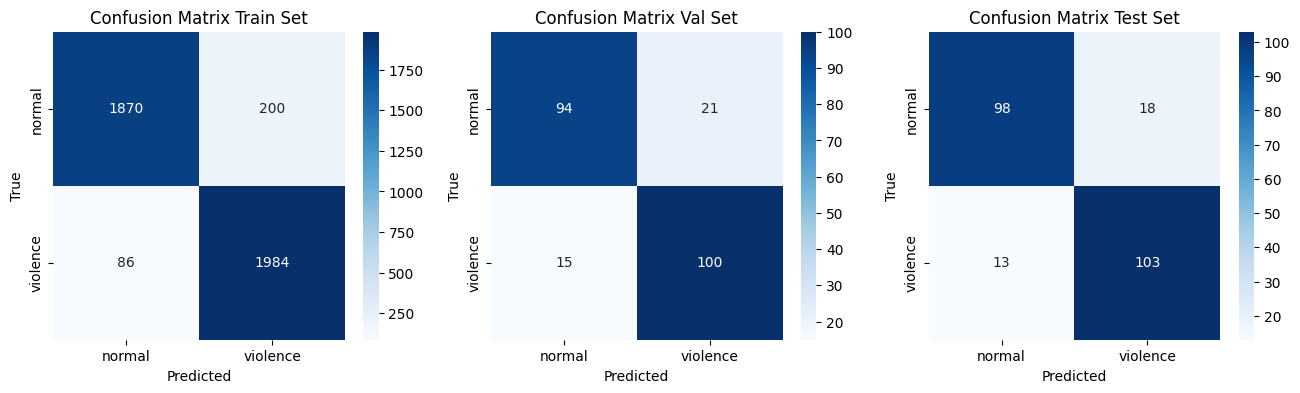

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.390600,0.526919,0.721739,0.740349,0.721739,0.716246
2,0.199200,0.500442,0.782609,0.791423,0.782609,0.780952
3,0.570300,0.467527,0.804348,0.807158,0.804348,0.803899
4,0.585900,0.491168,0.808696,0.816448,0.808696,0.807517
5,0.279300,0.451783,0.821739,0.821958,0.821739,0.821709
6,0.181600,0.468436,0.826087,0.826087,0.826087,0.826087
7,0.067900,0.455927,0.843478,0.845149,0.843478,0.843289
8,0.180700,0.445873,0.847826,0.848485,0.847826,0.847754
9,0.165000,0.475552,0.839130,0.839361,0.839130,0.839103
10,0.418000,0.467714,0.843478,0.843582,0.843478,0.843466


Train Set: {'accuracy': 0.9487922705314009, 'precision': 0.9490140058429283, 'recall': 0.9487922705314009, 'f1_score': 0.9493549928332538}
Val Set: {'accuracy': 0.8434782608695652, 'precision': 0.8438943144825499, 'recall': 0.8434782608695652, 'f1_score': 0.8461538461538461}
Test Set: {'accuracy': 0.8663793103448276, 'precision': 0.8670612761521852, 'recall': 0.8663793103448276, 'f1_score': 0.869198312236287}


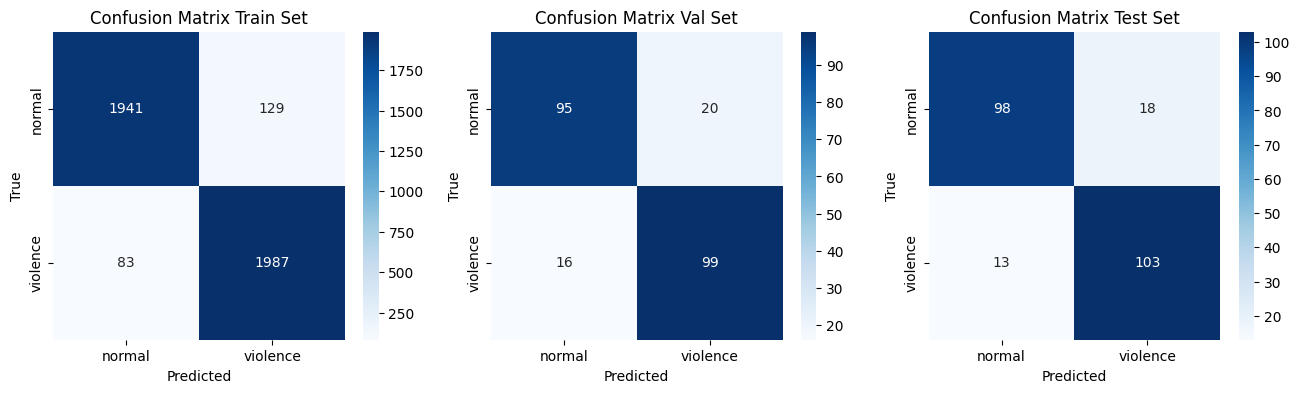

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.377000,0.513451,0.721739,0.737931,0.721739,0.716923
2,0.187500,0.487500,0.778261,0.783077,0.778261,0.777314
3,0.613300,0.458373,0.804348,0.807158,0.804348,0.803899
4,0.562500,0.487466,0.826087,0.836257,0.826087,0.824762
5,0.261700,0.443988,0.817391,0.817776,0.817391,0.817336
6,0.206100,0.469489,0.834783,0.836411,0.834783,0.834582
7,0.066400,0.436982,0.852174,0.853886,0.852174,0.851995
8,0.126000,0.446026,0.830435,0.830460,0.830435,0.830432
9,0.132800,0.485933,0.830435,0.830460,0.830435,0.830432
10,0.304700,0.479747,0.826087,0.826087,0.826087,0.826087


Train Set: {'accuracy': 0.95, 'precision': 0.950273322810948, 'recall': 0.95, 'f1_score': 0.9493763756419662}
Val Set: {'accuracy': 0.8521739130434782, 'precision': 0.8538864827900615, 'recall': 0.8521739130434782, 'f1_score': 0.8468468468468469}
Test Set: {'accuracy': 0.8620689655172413, 'precision': 0.8637992831541218, 'recall': 0.8620689655172413, 'f1_score': 0.8571428571428571}


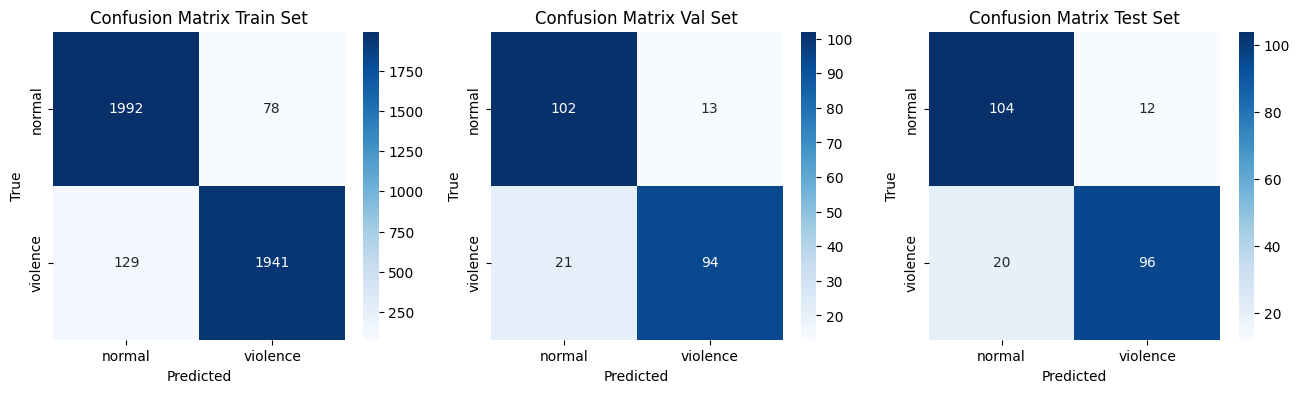

PyTorch: setting up devices


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.361300,0.507252,0.726087,0.741441,0.726087,0.721662
2,0.180700,0.479450,0.782609,0.785720,0.782609,0.782015
3,0.625000,0.458747,0.804348,0.807158,0.804348,0.803899
4,0.601600,0.485666,0.839130,0.853261,0.839130,0.837505
5,0.252000,0.448922,0.817391,0.818258,0.817391,0.817267
6,0.210900,0.470746,0.834783,0.835188,0.834783,0.834733
7,0.066900,0.431148,0.847826,0.849120,0.847826,0.847685
8,0.094200,0.460292,0.839130,0.839361,0.839130,0.839103
9,0.108900,0.502896,0.834783,0.834783,0.834783,0.834783
10,0.294900,0.497385,0.839130,0.839156,0.839130,0.839127


Train Set: {'accuracy': 0.9579710144927536, 'precision': 0.9583064363192367, 'recall': 0.9579710144927536, 'f1_score': 0.9573947110675808}
Val Set: {'accuracy': 0.8434782608695652, 'precision': 0.8444158010463265, 'recall': 0.8434782608695652, 'f1_score': 0.8392857142857143}
Test Set: {'accuracy': 0.853448275862069, 'precision': 0.8560946391135071, 'recall': 0.853448275862069, 'f1_score': 0.8468468468468469}


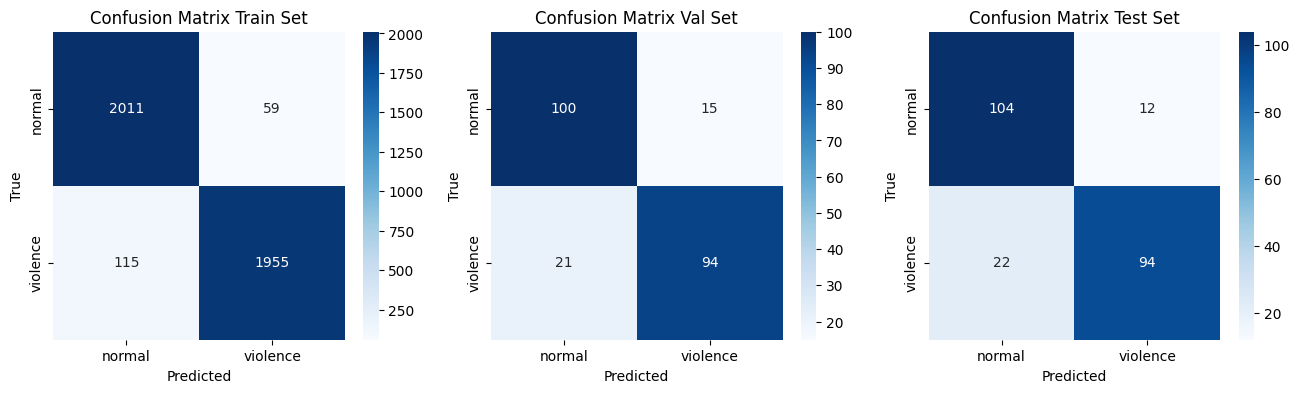

In [ ]:
trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=0.01)
lora_list = [{"lora_rank": 4, "scaling_factor":8}, {"lora_rank": 4, "scaling_factor":12}, {"lora_rank": 4, "scaling_factor":16},
             {"lora_rank": 4, "scaling_factor":20}, {"lora_rank": 8, "scaling_factor":16}, {"lora_rank": 8, "scaling_factor":24},
             {"lora_rank": 8, "scaling_factor": 32}, {"lora_rank": 8, "scaling_factor":40}, {"lora_rank": 16, "scaling_factor":32},
             {"lora_rank": 16, "scaling_factor":48}, {"lora_rank": 16, "scaling_factor":64}, {"lora_rank": 16, "scaling_factor":80}]

chosen_layers = list(range(12))
for lora in lora_list:
    lora_rank, scaling_factor = lora["lora_rank"], lora["scaling_factor"]
    #model
    model_class = GetModel(model_checkpoint)
    model_with_lora, model_info = model_class.get_model_with_lora(quantized = True, lora_rank = lora_rank, scaling_factor = scaling_factor, dropout = 0.1, chosen_layers = choosen_layers)

    #trainer
    trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=0.01)
    trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora, pytorch_train, pytorch_val)
    trainer.train()

    #evaluation
    # print(model_info, training_hyperparameters_info)
    # print("train set: ", trainer.evaluate(eval_dataset = pytorch_train))
    # print("val set: ", trainer.evaluate(eval_dataset = pytorch_val))
    # print("test set: ", trainer.evaluate(eval_dataset = pytorch_test))
    evaluation_class = EvaluationClass(model_with_lora, device, class_names, tokenizer)
    evaluation_class.set_info(model_info, training_hyperparameters_info)
    evaluation_class.plot_all_matrixes(pytorch_train, pytorch_val, pytorch_test)



## **Experiment 4**  hyperparameters

In [ ]:
def model_init():
    model_class = GetModel(model_checkpoint)
    model_with_lora_all, model_info_all = model_class.get_model_with_lora(quantized = True, lora_rank = 16, scaling_factor = 48, dropout = 0.1, chosen_layers = list(range(12)))
    return model_with_lora_all

trainer_class = GetTrainer(num_epochs = 15, lr = 1e-4, weight_decay=0.01)


In [ ]:
trainer = Trainer(
    model=None,
    model_init = model_init,
    args=trainer_class.training_args,
    train_dataset=pytorch_train,
    eval_dataset=pytorch_val,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=trainer_class.compute_metrics
)

best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space = lambda trial: {
        "learning_rate": trial.suggest_float("learning_rate", 5e-5, 5e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.005, 0.02),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32])
    },
    compute_objective = lambda metrics: metrics['eval_f1_score'],
    backend="optuna",
    n_trials=30,
    pruner = optuna.pruners.NopPruner(),
)

In [ ]:
print(best_run)

BestRun(run_id='26', objective=0.8826064764929393, hyperparameters={'learning_rate': 0.0004165609540141858, 'weight_decay': 0.009475839138198706, 'per_device_train_batch_size': 16}, run_summary=None)


**Test**

In [ ]:
model_class = GetModel(model_checkpoint)
model_with_lora_all, model_info_all = model_class.get_model_with_lora(quantized = True, lora_rank = 16, scaling_factor = 48, dropout = 0.1, chosen_layers = list(range(12)))
trainer_class = GetTrainer(num_epochs = 20, lr = 0.0004165609540141858, weight_decay=0.009475839138198706)
trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora_all, pytorch_train, pytorch_val)
trainer.train()

In [ ]:
print(model_info_all, training_hyperparameters_info)
print("train set: ", trainer.evaluate(eval_dataset = pytorch_train))
print("val set: ", trainer.evaluate(eval_dataset = pytorch_val))
print("test set: ", trainer.evaluate(eval_dataset = pytorch_test))

model is quantized 
lora_rank: 16, scaling_factor: 48, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 591362
 num_epochs: 20, learning_rate: 0.0004165609540141858, weight_decay: 0.009475839138198706


train set:  {'eval_loss': 0.0732245221734047, 'eval_accuracy': 0.976328502415459, 'eval_precision': 0.976364522417154, 'eval_recall': 0.976328502415459, 'eval_f1_score': 0.976328054930675, 'eval_runtime': 9.1094, 'eval_samples_per_second': 454.474, 'eval_steps_per_second': 28.432, 'epoch': 10.0}
val set:  {'eval_loss': 0.4694803059101105, 'eval_accuracy': 0.8652173913043478, 'eval_precision': 0.8652450090744103, 'eval_recall': 0.8652173913043478, 'eval_f1_score': 0.8652148433807823, 'eval_runtime': 0.5486, 'eval_samples_per_second': 419.211, 'eval_steps_per_second': 27.34, 'epoch': 10.0}
test set:  {'eval_loss': 0.4381987452507019, 'eval_accuracy': 0.8879310344827587, 'eval_precision': 0.8880463871543265, 'eval_recall': 0.8879310344827587, 'eval_f1_score': 0.8879227053140096, 'eval_runtime': 0.5557, 'eval_samples_per_second': 417.516, 'eval_steps_per_second': 26.995, 'epoch': 10.0}


Train Set: {'accuracy': 0.9765700483091787, 'precision': 0.9766021932912929, 'recall': 0.9765700483091787, 'f1_score': 0.9766658648063508}
Val Set: {'accuracy': 0.8652173913043478, 'precision': 0.8652450090744103, 'recall': 0.8652173913043478, 'f1_score': 0.8646288209606987}
Test Set: {'accuracy': 0.8922413793103449, 'precision': 0.8925039042165538, 'recall': 0.8922413793103449, 'f1_score': 0.8936170212765957}


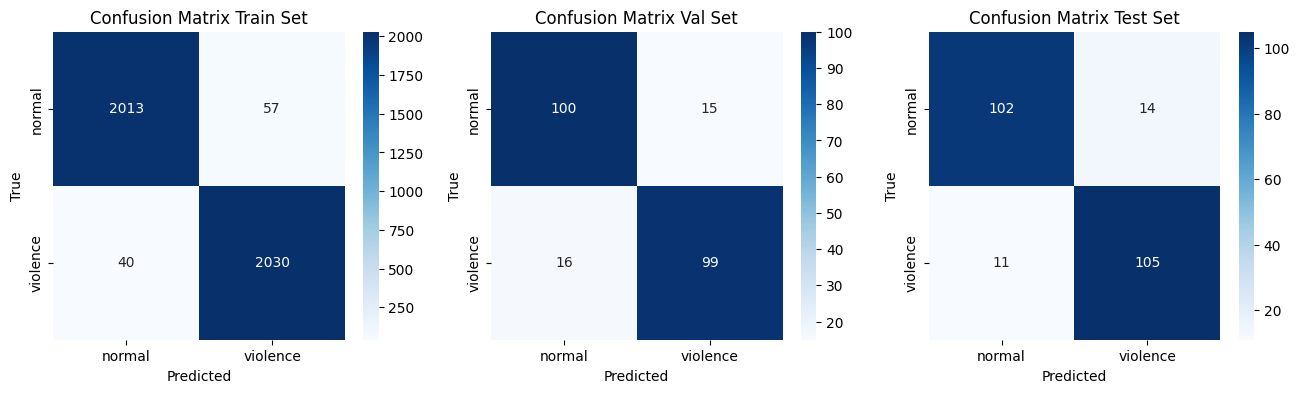

In [ ]:
evaluation_class = EvaluationClass(model_with_lora_all, device, class_names, tokenizer)
evaluation_class.set_info(model_info_all, training_hyperparameters_info)
evaluation_class.plot_all_matrixes(pytorch_train, pytorch_val, pytorch_test)

## **Experiment 5** Mining hard examples

In [ ]:
def collect_misclassified_examples(model, pytorch_dataset):
    misclassified_examples = []
    evaluation_class = EvaluationClass(model, device, class_names, tokenizer)

    for i in range(len(pytorch_dataset)):
        item = pytorch_dataset[i]
        predicted_label = evaluation_class.classify_input(item['input_ids'], item['attention_mask'])
        true_label = item['labels'].item()
        if predicted_label != true_label:
            misclassified_examples.append({
                'text': pytorch_dataset.texts[i],
                'label': true_label
            })

    random.shuffle(misclassified_examples)
    return misclassified_examples

In [ ]:
misclassified = collect_misclassified_examples(model_with_lora_all, pytorch_test)
print(misclassified)

[{'text': 'Bolje se ne sukobljavaj s njim, deo je grupe i mogli bi da te povrede.', 'label': 0}, {'text': 'Moj ti je savet da se ubiješ.', 'label': 1}, {'text': 'Ovako: Uhvatićemo je i prebaciti preko granice gde ćemo je prodati', 'label': 1}, {'text': 'Naći ću te čim te vidim na mapi, baš da isprobam novi item.', 'label': 0}, {'text': 'Ubij se, ne vredi ti ništa što radiš.', 'label': 1}, {'text': 'Izbrisaću ti nalog ovaj onda.', 'label': 0}, {'text': 'Učiteljice, Marko govori da će me napasti.', 'label': 0}, {'text': 'Neka se bore dok jedan od njih ne umre.', 'label': 1}, {'text': 'Kada te pronađem, reći ću ti par stvari.', 'label': 0}, {'text': 'Ajde da mu uzmemo poklon za njegov rođendan.', 'label': 0}, {'text': 'Tvoj dug će uskoro biti naplaćen tvojom krvlju!', 'label': 1}, {'text': 'Skratiću ti kosu 2 cm samo', 'label': 0}, {'text': 'Perica, čini se da ti je nos polomljen.', 'label': 0}, {'text': 'Napraviću logorsku vatru da nam ne bude hladno.', 'label': 0}, {'text': 'Svi belci ć

In [ ]:
def collect_all_plus_misclassified_examples(model, pytorch_dataset):
    all_plus_misclassified_examples = []
    evaluation_class = EvaluationClass(model, device, class_names, tokenizer)

    for i in range(len(pytorch_dataset)):
        item = pytorch_dataset[i]
        predicted_label = evaluation_class.classify_input(item['input_ids'], item['attention_mask'])
        true_label = item['labels'].item()
        if predicted_label != true_label:
            all_plus_misclassified_examples.append({
                'text': pytorch_dataset.texts[i],
                'label': true_label
            })
        all_plus_misclassified_examples.append({
                'text': pytorch_dataset.texts[i],
                'label': true_label
            })
    random.shuffle(all_plus_misclassified_examples)
    return SentimentDataset(all_plus_misclassified_examples, tokenizer, max_length)

In [ ]:
early_stopping_patience = 3
current_val_f1 = 0
best_eval_f1 = 0
best_eval_iteration = -1
best_model_so_far = None
iteration = -1

#model
model_with_lora_layers_all, model_info_all = model_class.get_model_with_lora(quantized = True, lora_rank = 16, scaling_factor = 48, dropout = 0.1, chosen_layers = list(range(12)))

trainer_class = GetTrainer(num_epochs = 1, lr = 0.00048569487626740564, weight_decay=0.008452656442872837)

#train set init
current_train_set = pytorch_train
#new_prediction = evaluation_class.classify_input(item['input_ids'], item['attention_mask'])

while(iteration < 15):
    iteration += 1
    print("current iteration: ", iteration, "current train set length: ", len(current_train_set))
    #trainer
    trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora_layers_all, current_train_set, pytorch_val)
    trainer.train()

    #evaluation`
    current_eval_f1 = trainer.evaluate(eval_dataset = pytorch_val)['eval_f1_score']
    print("train set: eval_f1: ", trainer.evaluate(eval_dataset = pytorch_train)['eval_f1_score'])
    print("val set: eval_f1: ", trainer.evaluate(eval_dataset = pytorch_val)['eval_f1_score'])

    if current_eval_f1 <= best_eval_f1 and iteration - best_eval_iteration >= early_stopping_patience:
        break
    elif current_eval_f1 > best_eval_f1:
        best_eval_f1 = current_eval_f1
        best_eval_iteration = iteration
        best_model_so_far = trainer.model

    print("best f1 so far: ", best_eval_f1, "is from iteration: ", best_eval_iteration)

    #new train dataset
    current_train_set = collect_all_plus_misclassified_examples(model_with_lora_layers_all, pytorch_train)

print("test set: ", trainer.evaluate(eval_dataset = pytorch_test))

Train Set: {'accuracy': 0.9946859903381643, 'precision': 0.9946859903381643, 'recall': 0.9946859903381643, 'f1_score': 0.9946859903381643}
Val Set: {'accuracy': 0.8869565217391304, 'precision': 0.8870735950381968, 'recall': 0.8869565217391304, 'f1_score': 0.8859649122807017}
Test Set: {'accuracy': 0.8663793103448276, 'precision': 0.8677183560826434, 'recall': 0.8663793103448276, 'f1_score': 0.8622222222222222}


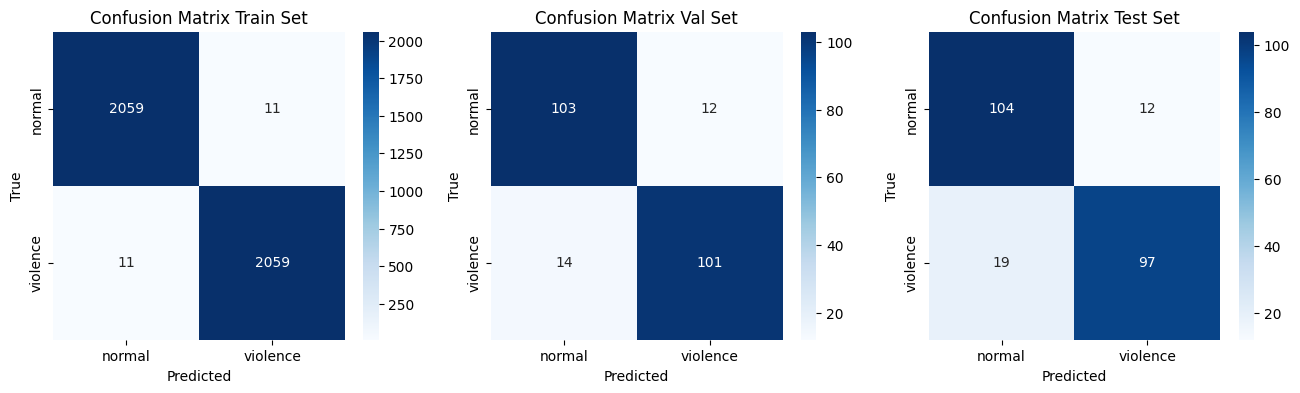

In [ ]:
evaluation_class = EvaluationClass(best_model_so_far, device, class_names, tokenizer)
evaluation_class.get_metrics(pytorch_test)

evaluation_class.plot_all_matrixes(pytorch_train, pytorch_val, pytorch_test)